In [4]:
import math
import random
from lib.learn_linear import sigmoid, one
from lib.learn_problem import Learner, Data_set, Data_from_file


class Layer(object):
    
    def __init__(self, nn, num_outputs=None):
        """Given a list of inputs, outputs will produce a list of length num_outputs.
        nn is the neural network this is part of
        num outputs is the number of outputs for this layer.
        """
        self.nn = nn
        self.num_inputs = nn.num_outputs # output of nn is the input to this layer
        if num_outputs:
            self.num_outputs = num_outputs
        else:
            self.num_outputs = nn.num_outputs  # same as the inputs

    def output_values(self, input_values):
        """Return the outputs for this layer for the given input values.
        input_values is a list of the inputs to this layer (of length num_inputs)
        returns a list of length self.num_outputs
        """
        raise NotImplementedError('output_values')    # abstract method

    def backprop(self, errors):
        """Backpropagate the errors on the outputs, return the errors on the inputs.
        errors is a list of errors for the outputs (of length self.num_outputs).
        Return the errors for the inputs to this layer (of length self.num_inputs).
        You can assume that this is only called after corresponding output_values, 
           and it can remember information information required for the backpropagation.
        """
        raise NotImplementedError('backprop')    # abstract method


In [5]:
class Linear_complete_layer(Layer):
    """a completely connected layer"""

    def __init__(self, nn, num_outputs, max_init=0.2):
        """A completely connected linear layer.
        nn is a neural network that the inputs come from
        num_outputs is the number of outputs
        max_init is the maximum value for random initialization of parameters
        """
        Layer.__init__(self, nn, num_outputs)
        # self.weights[o][i] is the weight between input i and output o
        self.weights = [
            [
                random.uniform(-max_init, max_init) for inf in range(self.num_inputs + 1)
            ]
            for outf in range(self.num_outputs)
        ]

    def output_values(self, input_values):
        """Returns the outputs for the input values.
        It remembers the values for the backprop.

        Note in self.weights there is a weight list for every output,
        so wts in self.weights effectively loops over the outputs.
        """
        self.inputs = input_values + [1]
        return [sum(w * val for (w, val) in zip(wts, self.inputs)) for wts in self.weights]

    def backprop(self, errors):
        """Backpropagate the errors, updating the weights and returning the error in its inputs.
        """
        input_errors = [0] * (self.num_inputs + 1)
        for out in range(self.num_outputs):
            for inp in range(self.num_inputs + 1):
                input_errors[inp] += self.weights[out][inp] * errors[out]
                self.weights[out][inp] += self.nn.learning_rate * self.inputs[inp] * errors[out]
        return input_errors[:-1]   # remove the error for the "1"


In [6]:
class Sigmoid_layer(Layer):
    """sigmoids of the inputs.
    The number of outputs is equal to the number of inputs. 
    Each output is the sigmoid of its corresponding input.
    """
    
    def __init__(self, nn):
        Layer.__init__(self, nn)

    def output_values(self, input_values):
        """Returns the outputs for the input values.
        It remembers the output values for the backprop.
        """
        self.outputs = [sigmoid(inp) for inp in input_values]
        return self.outputs

    def backprop(self, errors):
        """Returns the derivative of the errors"""
        return [e * out * (1 - out) for e, out in zip(errors, self.outputs)]


In [7]:
class ReLU_layer(Layer):
    """Rectified linear unit (ReLU) f(z) = max(0, z).
    The number of outputs is equal to the number of inputs. 
    """
    
    def __init__(self, nn):
        Layer.__init__(self, nn)

    def output_values(self, input_values):
        """Returns the outputs for the input values.
        It remembers the input values for the backprop.
        """
        self.input_values = input_values
        self.outputs = [max(0, inp) for inp in input_values]
        return self.outputs

    def backprop(self, errors):
        """Returns the derivative of the errors"""
        return [e if inp > 0 else 0 for e, inp in zip(errors, self.input_values)]


In [8]:
class NN(Learner):
    
    def __init__(self, dataset, learning_rate=0.1):
        self.dataset = dataset
        self.learning_rate = learning_rate
        self.input_features = dataset.input_features
        self.num_outputs = len(self.input_features)
        self.layers = []

    def add_layer(self, layer):
        """add a layer to the network.
        Each layer gets values from the previous layer.
        """
        self.layers.append(layer)
        self.num_outputs = layer.num_outputs

    def predictor(self, ex):
        """Predicts the value of the first output feature for example ex.
        """
        values = [f(ex) for f in self.input_features]
        for layer in self.layers:
            values = layer.output_values(values)
        return values[0]

    def predictor_string(self):
        return "not implemented"


    def learn(self, num_iter):
        """Learns parameters for a neural network using stochastic gradient decent.
        num_iter is the number of iterations
        """
        for i in range(num_iter):
            for e in random.sample(self.dataset.train, len(self.dataset.train)):
                # compute all outputs
                values = [f(e) for f in self.input_features]
                for layer in self.layers:
                    values = layer.output_values(values)
                # backpropagate
                errors = self.sum_squares_error([self.dataset.target(e)], values)
                for layer in reversed(self.layers):
                    errors = layer.backprop(errors)

    def sum_squares_error(self, observed, predicted):
        """Returns the errors for each of the target features.
        """
        return [obsd - pred for obsd, pred in zip(observed, predicted)]


In [9]:
data = Data_from_file('data/mail_reading.csv', target_index=-1)
#data = Data_from_file('data/mail_reading_consis.csv', target_index=-1)
#data = Data_from_file('data/SPECT.csv',  prob_test=0.5, target_index=0)
#data = Data_from_file('data/holiday.csv', target_index=-1) #, num_train=19)
nn1 = NN(data)
nn1.add_layer(Linear_complete_layer(nn1, 3))
nn1.add_layer(Sigmoid_layer(nn1))  # comment this or the next
# nn1.add_layer(ReLU_layer(nn1)) 
nn1.add_layer(Linear_complete_layer(nn1, 1))
nn1.add_layer(Sigmoid_layer(nn1))
nn1.learning_rate = 0.1
#nn1.learn(100)


Tuples read. 
Training set 23 examples. Number of columns: {5} 
Test set 5 examples. Number of columns: {5}
There are 4 input features


Train error: 0.25155629384484907 Test error: 0.2506309571721101
Train error: 0.24959440207178346 Test error: 0.24758840048416003
Train error: 0.24846581628067013 Test error: 0.24571685545785651
Train error: 0.24764312226162843 Test error: 0.2442325490188054
Train error: 0.24723404584834657 Test error: 0.2434951013116601
Train error: 0.24682031666941265 Test error: 0.24264439846553235
Train error: 0.2464842698374319 Test error: 0.24183784353463578
Train error: 0.24627803828212028 Test error: 0.24129760804749828
Train error: 0.24621479186112627 Test error: 0.2413876544253371
Train error: 0.24613135954111165 Test error: 0.24136917431227206
Train error: 0.24600420463617115 Test error: 0.24111637390866852
Train error: 0.24589278642989104 Test error: 0.24090467365889084
Train error: 0.24579190432208384 Test error: 0.24071827645219984
Train error: 0.2456977408379746 Test error: 0.2405274058761066
Train error: 0.24561573562037184 Test error: 0.24051988106654934
Train error: 0.24553055528111467

Train error: 0.08737387437971358 Test error: 0.22884237304519023
Train error: 0.08677385213182469 Test error: 0.22925978140596204
Train error: 0.086199578891721 Test error: 0.22988835379469394
Train error: 0.08562974805609617 Test error: 0.2299778885435826
Train error: 0.08507934479695672 Test error: 0.22972208107346148
Train error: 0.08454445651058162 Test error: 0.229570804794108
Train error: 0.08402256933131518 Test error: 0.23012619359574943
Train error: 0.0835071008717541 Test error: 0.23057970584013035
Train error: 0.08300977750505285 Test error: 0.23064060885212329
Train error: 0.0825205314009318 Test error: 0.23093139675154117
Train error: 0.08204437060333088 Test error: 0.23115228354613943
Train error: 0.08158011713991442 Test error: 0.23094910247289788
Train error: 0.08112960070052158 Test error: 0.23156721619386614
Train error: 0.08068630375365288 Test error: 0.2318501906516352
Train error: 0.08024745973463923 Test error: 0.2317645648724473
Train error: 0.07982492409007891 T

Train error: 0.05045098631366399 Test error: 0.2576830691373412
Train error: 0.050290935516449954 Test error: 0.2581295449435962
Train error: 0.050132675414136234 Test error: 0.25845815078294654
Train error: 0.04997276846559393 Test error: 0.25929382511633925
Train error: 0.04981661205632887 Test error: 0.26024754493802255
Train error: 0.04965959421991231 Test error: 0.26026696736267574
Train error: 0.049502782546877365 Test error: 0.2606110110834492
Train error: 0.04934768474975424 Test error: 0.26064316927237796
Train error: 0.04919450580150595 Test error: 0.26105943049851554
Train error: 0.04903922482770036 Test error: 0.2615522107648793
Train error: 0.04888722810638412 Test error: 0.2619246731914059
Train error: 0.048736973365277894 Test error: 0.2615786446913963
Train error: 0.04858561289027468 Test error: 0.26179730733072876
Train error: 0.048434403569625355 Test error: 0.2623330736730404
Train error: 0.048283146192957815 Test error: 0.2632268932728486
Train error: 0.048135034966

Train error: 0.034001357335852925 Test error: 0.3213814069419464
Train error: 0.033952471769473254 Test error: 0.32166258229624234
Train error: 0.03389866674850301 Test error: 0.32151525124170627
Train error: 0.033843701300249475 Test error: 0.32114356815464207
Train error: 0.03379293278097488 Test error: 0.32134848401511995
Train error: 0.03374408961133808 Test error: 0.32143338096515284
Train error: 0.03369761516360351 Test error: 0.32204064433044877
Train error: 0.03364859292899601 Test error: 0.32149752393743203
Train error: 0.03360266452942206 Test error: 0.32147509610023645
Train error: 0.033556212637655826 Test error: 0.32156420417896514
Train error: 0.033511470673270004 Test error: 0.32145058266819143
Train error: 0.03346942649243004 Test error: 0.32136225831327964
Train error: 0.03342704756913808 Test error: 0.3213686160383702
Train error: 0.03338777339039621 Test error: 0.3212753021095421
Train error: 0.033329232200553637 Test error: 0.32227446557359996
Train error: 0.0332781

Train error: 0.029150831517975265 Test error: 0.3439378731219418
Train error: 0.029128631115446883 Test error: 0.3440759115270819
Train error: 0.029105327656932366 Test error: 0.3443097651612096
Train error: 0.029083593645817574 Test error: 0.3449805396132136
Train error: 0.02906017789456324 Test error: 0.3445232007765676
Train error: 0.029037443264981574 Test error: 0.3448283001995602
Train error: 0.029016539211606674 Test error: 0.34524546430384606
Train error: 0.028994539420200024 Test error: 0.34524088727429053
Train error: 0.028973142796644445 Test error: 0.34497664144858725
Train error: 0.02895057104966757 Test error: 0.3452005357881962
Train error: 0.028928679591872893 Test error: 0.3453050995661378
Train error: 0.028906930900733128 Test error: 0.3453732740760433
Train error: 0.028885261797978727 Test error: 0.3455371824740374
Train error: 0.02886631336026008 Test error: 0.34513667266753845
Train error: 0.028845373405181073 Test error: 0.3452563451721069
Train error: 0.028826901

Train error: 0.02623757768216801 Test error: 0.3586559831190367
Train error: 0.02622852071096101 Test error: 0.3586902109764406
Train error: 0.026221053696724693 Test error: 0.3586365909659558
Train error: 0.02621049003675533 Test error: 0.3587545055466744
Train error: 0.026194865405374315 Test error: 0.35926169632162813
Train error: 0.026183554449114983 Test error: 0.3596531224667947
Train error: 0.026175135293701503 Test error: 0.3594935305078014
Train error: 0.026164242750875227 Test error: 0.3598204849182077
Train error: 0.026155504486857974 Test error: 0.35957792728941906
Train error: 0.026144975081585878 Test error: 0.3598115704295317
Train error: 0.026135785397602876 Test error: 0.36019154855895363
Train error: 0.02612653613026847 Test error: 0.36029715685845154
Train error: 0.0261171516140659 Test error: 0.36040188872837714
Train error: 0.026110014849902326 Test error: 0.36065377335824345
Train error: 0.02609852889823093 Test error: 0.3604143029685198
Train error: 0.02609193066

Train error: 0.024525723565344364 Test error: 0.36915705863043924
Train error: 0.02452171662744204 Test error: 0.36935051003962543
Train error: 0.024517303854180827 Test error: 0.36919238797095033
Train error: 0.02451327506218004 Test error: 0.36944728338597627
Train error: 0.02450867817916827 Test error: 0.36930236187246746
Train error: 0.02450446749988127 Test error: 0.36945481291840204
Train error: 0.02450092539512519 Test error: 0.3696005513319217
Train error: 0.024497711986327494 Test error: 0.3697276210808565
Train error: 0.024494743287448887 Test error: 0.36984995256608144
Train error: 0.024487512964694532 Test error: 0.3696040563569766
Train error: 0.024485569639295192 Test error: 0.3698790557352433
Train error: 0.024482402020166234 Test error: 0.3699673048968898
Train error: 0.02447538356091666 Test error: 0.3697309529189476
Train error: 0.024470650038891924 Test error: 0.36959632395301817
Train error: 0.024467025773315495 Test error: 0.3693437625854575
Train error: 0.02446399

Train error: 0.02396765190894246 Test error: 0.37299816308680434
Train error: 0.023966278979646823 Test error: 0.3731517255687163
Train error: 0.023961781469999128 Test error: 0.3729669974303491
Train error: 0.023958888637712214 Test error: 0.3727389620767103
Train error: 0.023957313666566418 Test error: 0.37257819511176327
Train error: 0.023956393982219958 Test error: 0.3724696581455488
Train error: 0.02395087627651534 Test error: 0.37270128054694784
Train error: 0.023950123380139896 Test error: 0.37252797489458767
Train error: 0.023944396801011462 Test error: 0.3728546655408024
Train error: 0.02394121396138481 Test error: 0.37304068190314693
Train error: 0.023938889865223956 Test error: 0.37288052206293987
Train error: 0.023937081204517933 Test error: 0.372785524865921
Train error: 0.023937158808777555 Test error: 0.37257171050368426
Train error: 0.023935522420882024 Test error: 0.37254308553988114
Train error: 0.023929368608154356 Test error: 0.37277076520390456
Train error: 0.02392

Train error: 0.023571550647788646 Test error: 0.3754825518853929
Train error: 0.023570193646880067 Test error: 0.37535665479993663
Train error: 0.02356747848365922 Test error: 0.37553030004098087
Train error: 0.023566033304565304 Test error: 0.3754159995379032
Train error: 0.02356357862833057 Test error: 0.3755415575475034
Train error: 0.02356251905136519 Test error: 0.3753595028929476
Train error: 0.02356208870970983 Test error: 0.3752590337052669
Train error: 0.02355801796090825 Test error: 0.37546509443329823
Train error: 0.023557615578729398 Test error: 0.3753127759156106
Train error: 0.023557047389576216 Test error: 0.37524562453426374
Train error: 0.023552526258105874 Test error: 0.3754423510229877
Train error: 0.023551879797295276 Test error: 0.3753553089059266
Train error: 0.023552011827736273 Test error: 0.3752473309383809
Train error: 0.023547574674034587 Test error: 0.37541292369524704
Train error: 0.023544194920233696 Test error: 0.37557024583347287
Train error: 0.023541745

Train error: 0.023290502032374875 Test error: 0.37806106434923026
Train error: 0.02329076186572175 Test error: 0.3781534770494909
Train error: 0.02329078780771396 Test error: 0.3782189638458409
Train error: 0.023285033001787154 Test error: 0.3780383290340909
Train error: 0.0232860096509705 Test error: 0.37817471750855375
Train error: 0.02328142256919905 Test error: 0.3780215974740984
Train error: 0.02327807661317417 Test error: 0.377787255770605
Train error: 0.023277318120138862 Test error: 0.37757219400672576
Train error: 0.023276788113180978 Test error: 0.3775102211654789
Train error: 0.023273895278061518 Test error: 0.3776748610371472
Train error: 0.02327222739491797 Test error: 0.377836303332599
Train error: 0.023270977329749473 Test error: 0.3777120687883504
Train error: 0.023270497938505698 Test error: 0.37760390057371096
Train error: 0.0232716249385912 Test error: 0.3774262787968737
Train error: 0.023271823722470487 Test error: 0.377368005990342
Train error: 0.02327187753365209 

Train error: 0.023068782648823026 Test error: 0.37920968684377904
Train error: 0.023069332085543782 Test error: 0.3791400741763514
Train error: 0.023069933565870056 Test error: 0.3790843912049604
Train error: 0.023065263419534566 Test error: 0.3792609104980065
Train error: 0.023065927926997812 Test error: 0.3791786958123922
Train error: 0.02306688704156932 Test error: 0.37910702404440993
Train error: 0.02306187714436953 Test error: 0.37930031561777444
Train error: 0.023062016124116413 Test error: 0.3792476243818954
Train error: 0.023064002685280468 Test error: 0.3791120487145061
Train error: 0.023058494438900835 Test error: 0.37933020101671955
Train error: 0.02305569809023728 Test error: 0.3794871629689478
Train error: 0.023054174237345064 Test error: 0.3796036008995037
Train error: 0.02305333261263642 Test error: 0.37971075059688114
Train error: 0.023053006852801462 Test error: 0.37980198451539054
Train error: 0.02305092255317165 Test error: 0.3796565643006172
Train error: 0.023050451

Train error: 0.02289760983254087 Test error: 0.3809795749437005
Train error: 0.022897407591205 Test error: 0.38107551218915925
Train error: 0.022897965479243075 Test error: 0.381182822075517
Train error: 0.022898721046928767 Test error: 0.3812623664344572
Train error: 0.02289518640390514 Test error: 0.3811217337903146
Train error: 0.022893135706175155 Test error: 0.3809291430489701
Train error: 0.022892707720727327 Test error: 0.38105238086528825
Train error: 0.022893352723826185 Test error: 0.3811861968427681
Train error: 0.0228908427724795 Test error: 0.38103007370072095
Train error: 0.022890757352150085 Test error: 0.3811385156987132
Train error: 0.022889003576772052 Test error: 0.3809944078679508
Train error: 0.022889055955313885 Test error: 0.3811462418719917
Train error: 0.022887401027508646 Test error: 0.38100567500949456
Train error: 0.022887041126252637 Test error: 0.3811191966198005
Train error: 0.022885813936576183 Test error: 0.38093218165616627
Train error: 0.0228859925069

Train error: 0.022764517092161048 Test error: 0.3819316489234399
Train error: 0.022762449056957026 Test error: 0.38207666786284467
Train error: 0.022761684408248106 Test error: 0.3821890193256822
Train error: 0.02276178063692987 Test error: 0.38229381953413305
Train error: 0.022762498825350492 Test error: 0.38239119322099396
Train error: 0.022759958936554716 Test error: 0.3822575257455381
Train error: 0.02275899122086031 Test error: 0.3821299450898314
Train error: 0.022759038145816507 Test error: 0.3820326806572348
Train error: 0.02275984056519688 Test error: 0.381941347334845
Train error: 0.022761561696194525 Test error: 0.38183255844021524
Train error: 0.0227575278902985 Test error: 0.38200989582653144
Train error: 0.022755713967373033 Test error: 0.38214321379045435
Train error: 0.022756140922123257 Test error: 0.38202561279031266
Train error: 0.022754376745125066 Test error: 0.382157697196399
Train error: 0.02275374664399143 Test error: 0.3822649990987153
Train error: 0.02275318997

Train error: 0.022675990730669317 Test error: 0.38250372531094123
Train error: 0.0226685011073388 Test error: 0.3826978641624398
Train error: 0.022670184615752317 Test error: 0.3826393807182476
Train error: 0.022673025447109058 Test error: 0.3825479500039403
Train error: 0.02266575039641556 Test error: 0.3827535621888967
Train error: 0.022662279916995064 Test error: 0.38289539368418124
Train error: 0.02266353302498673 Test error: 0.3828122914834698
Train error: 0.02266032847404773 Test error: 0.3829898262608038
Train error: 0.02266173839117192 Test error: 0.382852029507178
Train error: 0.02266393168631609 Test error: 0.3827387338960855
Train error: 0.02266551126486883 Test error: 0.3826793328986785
Train error: 0.022659843973506216 Test error: 0.3828865154338697
Train error: 0.0226619574371953 Test error: 0.38277220104127235
Train error: 0.022664425389137377 Test error: 0.38267796906235085
Train error: 0.02266586950013084 Test error: 0.3826340419818349
Train error: 0.022659690392163246

Train error: 0.022576266099279912 Test error: 0.3839393380717855
Train error: 0.022575725022821968 Test error: 0.38381599635173125
Train error: 0.02257524375210657 Test error: 0.38392625820930826
Train error: 0.022574891659049457 Test error: 0.38381520297375754
Train error: 0.022574460793686014 Test error: 0.3839494572647661
Train error: 0.022573977824427053 Test error: 0.38384316885819836
Train error: 0.0225746007843661 Test error: 0.3837428622697975
Train error: 0.022576319766219904 Test error: 0.38363064277935716
Train error: 0.0225733890824087 Test error: 0.383765747128733
Train error: 0.022572066571979604 Test error: 0.3839257343061498
Train error: 0.022572152848165966 Test error: 0.38381936576384945
Train error: 0.022571217725284858 Test error: 0.383968515453801
Train error: 0.02257108643142167 Test error: 0.3838571972377279
Train error: 0.02257042932129231 Test error: 0.38400107855061283
Train error: 0.022570982107858018 Test error: 0.384109456207001
Train error: 0.0225695065084

Train error: 0.022502666807775934 Test error: 0.38480237611982576
Train error: 0.022503757847544315 Test error: 0.38488234182237024
Train error: 0.022501250656923554 Test error: 0.3847455200230178
Train error: 0.02250198034666413 Test error: 0.38483499427375145
Train error: 0.022500293754269964 Test error: 0.384708788954211
Train error: 0.022500724801335494 Test error: 0.38481200125207315
Train error: 0.02250222746420679 Test error: 0.3849207219955309
Train error: 0.022499480858627963 Test error: 0.38477253390708416
Train error: 0.022498936817586846 Test error: 0.3846259959713894
Train error: 0.022499663647277127 Test error: 0.3845324665800801
Train error: 0.022501637531662382 Test error: 0.3844194842872153
Train error: 0.022498213761184868 Test error: 0.38459874405444366
Train error: 0.022497273240632124 Test error: 0.3847233543760351
Train error: 0.02249759468516199 Test error: 0.38482748933944666
Train error: 0.022496538492309225 Test error: 0.3847156621867308
Train error: 0.0224969

Train error: 0.022441577076366376 Test error: 0.3851358167347483
Train error: 0.02243903365428619 Test error: 0.3852710089778196
Train error: 0.02243831915145158 Test error: 0.3853958257441953
Train error: 0.02243878280470647 Test error: 0.3854929954898921
Train error: 0.022437627148596824 Test error: 0.38535048295230095
Train error: 0.022438077507589724 Test error: 0.38525559568572415
Train error: 0.022439588265458162 Test error: 0.38515795528449515
Train error: 0.022436977887461265 Test error: 0.3853180117832572
Train error: 0.02243645199728466 Test error: 0.38541855789653645
Train error: 0.02243642674521841 Test error: 0.3853146671103881
Train error: 0.022435844570883347 Test error: 0.38542702852976424
Train error: 0.022435761826782284 Test error: 0.38532818185598355
Train error: 0.022436706619992492 Test error: 0.3852349775637829
Train error: 0.022438110480736132 Test error: 0.38516436887397587
Train error: 0.02243993518020532 Test error: 0.3850996878818075
Train error: 0.022442070

Train error: 0.022396769921259854 Test error: 0.38624614041415334
Train error: 0.02239148523137132 Test error: 0.3860946834524314
Train error: 0.02239341737120762 Test error: 0.3861755519397529
Train error: 0.02239488271070203 Test error: 0.3862230288757472
Train error: 0.02239761801617874 Test error: 0.3863007174461893
Train error: 0.022390852008722862 Test error: 0.38612257536745964
Train error: 0.02239294193866595 Test error: 0.38620290112649
Train error: 0.02238889220822624 Test error: 0.386065471700317
Train error: 0.0223901118808329 Test error: 0.38613251742374793
Train error: 0.022391608335049707 Test error: 0.3861929246661489
Train error: 0.022393288733845468 Test error: 0.38624770633692673
Train error: 0.022388343379190684 Test error: 0.3860982515886612
Train error: 0.02238958754660725 Test error: 0.3861592145746074
Train error: 0.022391959555463466 Test error: 0.38624540560972215
Train error: 0.02238707192832929 Test error: 0.38608256536491614
Train error: 0.02238857851377286

Train error: 0.0223518702122611 Test error: 0.38599495944161066
Train error: 0.022353755002140496 Test error: 0.3859660132925037
Train error: 0.02234472457094627 Test error: 0.38614047375230814
Train error: 0.022339345236559564 Test error: 0.38631403332634123
Train error: 0.0223373340458898 Test error: 0.3864393172121215
Train error: 0.022338258613897464 Test error: 0.3863536855811857
Train error: 0.022336762061341175 Test error: 0.3864698954635917
Train error: 0.022336727792847653 Test error: 0.3865653740839757
Train error: 0.022337971706736556 Test error: 0.38667340742238265
Train error: 0.022339426836012876 Test error: 0.3867399943708122
Train error: 0.022341937002741154 Test error: 0.38682589930131334
Train error: 0.02233699862492505 Test error: 0.38666694003839236
Train error: 0.022335384270877646 Test error: 0.38654311085581733
Train error: 0.022335548712239712 Test error: 0.38644070698498395
Train error: 0.022337050194427863 Test error: 0.38633628778656026
Train error: 0.0223390

Train error: 0.022288168187691734 Test error: 0.38699264834983277
Train error: 0.022286883839508564 Test error: 0.3871068306644591
Train error: 0.022287146051901126 Test error: 0.38720471341282015
Train error: 0.022288322760462293 Test error: 0.3872836212127436
Train error: 0.02228986538850435 Test error: 0.3873467732685526
Train error: 0.022292187408488814 Test error: 0.38741649617878693
Train error: 0.022294241546716352 Test error: 0.3874646321021759
Train error: 0.022288442860615713 Test error: 0.38732016715554757
Train error: 0.0222859543796038 Test error: 0.3871985536551178
Train error: 0.022285534047591583 Test error: 0.3870935541781232
Train error: 0.022286451190844245 Test error: 0.38700368417048525
Train error: 0.022285103140090138 Test error: 0.3871285710626948
Train error: 0.022285516137194143 Test error: 0.3872363609259513
Train error: 0.022284799165447698 Test error: 0.3871098151582947
Train error: 0.02228495660627948 Test error: 0.38722448802467535
Train error: 0.02228607

Train error: 0.022251587917506307 Test error: 0.3874164297400442
Train error: 0.02225347692071773 Test error: 0.3873446407634729
Train error: 0.022255785946601575 Test error: 0.38728316457309087
Train error: 0.022258169817168116 Test error: 0.3872304852666199
Train error: 0.022261432769682062 Test error: 0.3871636801490651
Train error: 0.022254145902501254 Test error: 0.3873146479290285
Train error: 0.022250093564002645 Test error: 0.3874605756567414
Train error: 0.02224883634465369 Test error: 0.3875802276043791
Train error: 0.02224938857961514 Test error: 0.38749388903527543
Train error: 0.022248549638532115 Test error: 0.38760535563652176
Train error: 0.022249150873802418 Test error: 0.3874880918193161
Train error: 0.022248215143429374 Test error: 0.38759164223067055
Train error: 0.022248748115635465 Test error: 0.3876880129615726
Train error: 0.022250021311882105 Test error: 0.3877606024612061
Train error: 0.02225204200517419 Test error: 0.38783248237121903
Train error: 0.022253755

Train error: 0.022220939783514648 Test error: 0.3880150821313529
Train error: 0.02222202249471166 Test error: 0.3881107548682806
Train error: 0.02222054751892402 Test error: 0.3879821531558213
Train error: 0.022221014998535838 Test error: 0.3880689047811731
Train error: 0.02222265747918543 Test error: 0.38815782253680253
Train error: 0.022220397127468546 Test error: 0.3880451548967482
Train error: 0.022221535682851287 Test error: 0.3881270777012594
Train error: 0.022219915552832325 Test error: 0.38801591817198194
Train error: 0.02222011681800089 Test error: 0.38792434458757163
Train error: 0.02221964112624595 Test error: 0.38801629732887205
Train error: 0.022220320949468 Test error: 0.3880963185456682
Train error: 0.022221705246924395 Test error: 0.3881645905457637
Train error: 0.022223390270385127 Test error: 0.38821941302730273
Train error: 0.02222611060541647 Test error: 0.38829197372455404
Train error: 0.022228255914011983 Test error: 0.38833434968388997
Train error: 0.022221923577

Train error: 0.02218746345969946 Test error: 0.3884286549669014
Train error: 0.02218772064688896 Test error: 0.38833581107794435
Train error: 0.022189402330293487 Test error: 0.3882413993546103
Train error: 0.022191405216793077 Test error: 0.3881798810217018
Train error: 0.022194358109447018 Test error: 0.38810718215455686
Train error: 0.022189077648479008 Test error: 0.3882460474211023
Train error: 0.02218695469871661 Test error: 0.38835691474132783
Train error: 0.022186673222166366 Test error: 0.38845336433077887
Train error: 0.02218771184124159 Test error: 0.38854124113197536
Train error: 0.022189409857099184 Test error: 0.38861128214449425
Train error: 0.022191278383772165 Test error: 0.38866273015622277
Train error: 0.022187227895231237 Test error: 0.3885382185694521
Train error: 0.022185979879705064 Test error: 0.3884362014084861
Train error: 0.022186728819612034 Test error: 0.38852913563151714
Train error: 0.02218842162856659 Test error: 0.3886073302528389
Train error: 0.0221859

Train error: 0.02217001617722034 Test error: 0.38879046903955994
Train error: 0.022171773719023322 Test error: 0.38885328185789464
Train error: 0.022168896376781478 Test error: 0.38874458146771723
Train error: 0.022168239039680952 Test error: 0.3886350772739308
Train error: 0.022168340180366324 Test error: 0.38871717049370746
Train error: 0.022168084324754117 Test error: 0.3886281189488025
Train error: 0.022169187193926913 Test error: 0.3885446923119753
Train error: 0.022167808249865008 Test error: 0.38864260274803486
Train error: 0.022168828790853464 Test error: 0.3885513000179367
Train error: 0.022170526327331175 Test error: 0.3884861607647711
Train error: 0.02216784853505785 Test error: 0.38860615868723364
Train error: 0.02216743697065162 Test error: 0.3887089854766352
Train error: 0.022168526119948892 Test error: 0.3888006035837835
Train error: 0.022167165118599064 Test error: 0.3886994474862159
Train error: 0.02216802306618378 Test error: 0.3887927863233833
Train error: 0.02216693

Train error: 0.02215341700442237 Test error: 0.3888675154097213
Train error: 0.022153389874189477 Test error: 0.38895779343656434
Train error: 0.022154539212530733 Test error: 0.3890341144081793
Train error: 0.022156525503589167 Test error: 0.3891037204853341
Train error: 0.02215348591131696 Test error: 0.38899233138843764
Train error: 0.022152860454215915 Test error: 0.3888822032136179
Train error: 0.02215407468798881 Test error: 0.38878491227170436
Train error: 0.022155866083874754 Test error: 0.3887217804308423
Train error: 0.022152974933182207 Test error: 0.38884391463030693
Train error: 0.02215249123985725 Test error: 0.3889510654460253
Train error: 0.02215264437108862 Test error: 0.3888641816088593
Train error: 0.0221523271397316 Test error: 0.3889591470099368
Train error: 0.022153289538160422 Test error: 0.3890362782450444
Train error: 0.0221520310017056 Test error: 0.3889293228213574
Train error: 0.02215263486072036 Test error: 0.3888388948339874
Train error: 0.0221518710659086

Train error: 0.022135423756119675 Test error: 0.38896072744533144
Train error: 0.02213771664564465 Test error: 0.38890397365549567
Train error: 0.022133478156623275 Test error: 0.38903005172465105
Train error: 0.022135293151312276 Test error: 0.3889674139323146
Train error: 0.022138168743816716 Test error: 0.38889332501392004
Train error: 0.022141171647211695 Test error: 0.38883493328640323
Train error: 0.02213515429903655 Test error: 0.38896281760511797
Train error: 0.02213228616724252 Test error: 0.3890723040806899
Train error: 0.022131593642943558 Test error: 0.389163729784512
Train error: 0.022132111633707256 Test error: 0.3890742343978145
Train error: 0.022131468338208695 Test error: 0.38917587057105096
Train error: 0.02213222793689407 Test error: 0.3892511472155509
Train error: 0.022131268683587932 Test error: 0.3891532022409604
Train error: 0.022131797382392904 Test error: 0.3892407576959605
Train error: 0.02213112851565158 Test error: 0.3891421689007995
Train error: 0.022132056

Train error: 0.022122875521654532 Test error: 0.38947222637117906
Train error: 0.022124844491192543 Test error: 0.3895263550339795
Train error: 0.022121163610502207 Test error: 0.38941534343527284
Train error: 0.022120104530668285 Test error: 0.38932000631405095
Train error: 0.022120621094677446 Test error: 0.389396556142637
Train error: 0.02212215729559597 Test error: 0.38946815388816786
Train error: 0.022120041340507775 Test error: 0.38936350325662644
Train error: 0.02212130766752563 Test error: 0.38944708675213585
Train error: 0.022119722075180474 Test error: 0.38933530227280017
Train error: 0.022120463255521736 Test error: 0.3894149780793825
Train error: 0.022119561683840997 Test error: 0.38930667385045004
Train error: 0.022120450406289256 Test error: 0.38922326139782965
Train error: 0.02211938941742619 Test error: 0.3893298529507651
Train error: 0.02211996024045215 Test error: 0.3892492928779218
Train error: 0.02212178413530701 Test error: 0.3891680460991584
Train error: 0.0221241

Train error: 0.02210898419658431 Test error: 0.3893980567681479
Train error: 0.02211058095557957 Test error: 0.389322606554933
Train error: 0.022112857474170463 Test error: 0.38925944380728483
Train error: 0.02210930483318587 Test error: 0.38937061540218737
Train error: 0.022111120966720462 Test error: 0.38930349201016773
Train error: 0.022108486369489432 Test error: 0.38941803277559195
Train error: 0.022108101829579885 Test error: 0.3895029054124833
Train error: 0.022108335365911662 Test error: 0.38942090100146787
Train error: 0.022109767327252512 Test error: 0.3893470980265229
Train error: 0.022112234138332125 Test error: 0.3892725038595565
Train error: 0.022114680735876857 Test error: 0.3892209687871208
Train error: 0.022117737624210484 Test error: 0.38916541074630284
Train error: 0.022120759611865857 Test error: 0.38911864649064754
Train error: 0.022112959633532596 Test error: 0.3892526919460923
Train error: 0.022108847247865854 Test error: 0.3893699998339377
Train error: 0.0221074

Train error: 0.022099573653064794 Test error: 0.38952769601833154
Train error: 0.02209822996548572 Test error: 0.3896309590794527
Train error: 0.02209904054763207 Test error: 0.3895527262857243
Train error: 0.02209809084259767 Test error: 0.38965636123710923
Train error: 0.022098693199900123 Test error: 0.38972849458859116
Train error: 0.02210024349194511 Test error: 0.3897947828594419
Train error: 0.022102602375051846 Test error: 0.38986084262883863
Train error: 0.022098890122223925 Test error: 0.3897536363055672
Train error: 0.02210067930772998 Test error: 0.389819196745257
Train error: 0.02210279438860705 Test error: 0.38987061954335345
Train error: 0.022098821519533927 Test error: 0.3897614144976416
Train error: 0.022097543620870554 Test error: 0.38965987474399494
Train error: 0.022098316349649726 Test error: 0.3897479346304641
Train error: 0.02209741916787505 Test error: 0.38965694690730046
Train error: 0.02209806434885405 Test error: 0.38958076633001537
Train error: 0.02209961950

Train error: 0.0220886716785603 Test error: 0.3897318733611261
Train error: 0.022087967841334415 Test error: 0.3898211375703251
Train error: 0.022088859236453602 Test error: 0.389907739609742
Train error: 0.022087836718962722 Test error: 0.38980218456929994
Train error: 0.0220886242543443 Test error: 0.38972420799940444
Train error: 0.022087703949333334 Test error: 0.38981321807764463
Train error: 0.02208839560317113 Test error: 0.3897306196648559
Train error: 0.022090165379527703 Test error: 0.38965967729503775
Train error: 0.02208785521085289 Test error: 0.3897619732361535
Train error: 0.02208761868865645 Test error: 0.3898583942530121
Train error: 0.022087739431858783 Test error: 0.3897646703083019
Train error: 0.022087428712376213 Test error: 0.3898511850085546
Train error: 0.02208769448063202 Test error: 0.3897564226503468
Train error: 0.0220872398994179 Test error: 0.3898388749658623
Train error: 0.02208808255071564 Test error: 0.38991232202393195
Train error: 0.02208998548045074

Train error: 0.022081880076758018 Test error: 0.390144792127728
Train error: 0.02208412243225038 Test error: 0.39019017189364924
Train error: 0.022079438774462393 Test error: 0.3900811274988297
Train error: 0.02208141559319183 Test error: 0.3901378934252233
Train error: 0.022078231653317373 Test error: 0.3900361959330299
Train error: 0.022077448928080487 Test error: 0.389944812877353
Train error: 0.022077860919075952 Test error: 0.3900209072739095
Train error: 0.02207737683788539 Test error: 0.3899352159351364
Train error: 0.022078482574479818 Test error: 0.3898503587445636
Train error: 0.022080742916508286 Test error: 0.3897729233130665
Train error: 0.022077866748473934 Test error: 0.38987181332013726
Train error: 0.022077111507607626 Test error: 0.38997154032897613
Train error: 0.022077641953914307 Test error: 0.38988116602718204
Train error: 0.02207954154889728 Test error: 0.38980035277472236
Train error: 0.022077237803825554 Test error: 0.3898985530875536
Train error: 0.02207866354

Train error: 0.022070329942483372 Test error: 0.390157271139146
Train error: 0.022072011191085067 Test error: 0.390212777116676
Train error: 0.022069302884718124 Test error: 0.3901055146630377
Train error: 0.022070558378387162 Test error: 0.3901720456958178
Train error: 0.022072536750600145 Test error: 0.3902314767220303
Train error: 0.02207505606198111 Test error: 0.39028705704615996
Train error: 0.02207789153046269 Test error: 0.39033799440126565
Train error: 0.022080023941542938 Test error: 0.3903678495182913
Train error: 0.02207298103547124 Test error: 0.39025241892441953
Train error: 0.022069539282043093 Test error: 0.3901510168597998
Train error: 0.02206856066878351 Test error: 0.3900493395413996
Train error: 0.022068990354374717 Test error: 0.3901254524761138
Train error: 0.022068497415572152 Test error: 0.39004040666147
Train error: 0.022069472889224527 Test error: 0.38996448590598887
Train error: 0.022068342203714304 Test error: 0.3900583787440056
Train error: 0.02206885150937

Train error: 0.022062692364502562 Test error: 0.39003489370387806
Train error: 0.022060757804792764 Test error: 0.39013523865250466
Train error: 0.022061870293023433 Test error: 0.39006593555811253
Train error: 0.022060537152763203 Test error: 0.3901643851463279
Train error: 0.02206134048249397 Test error: 0.39009052339102585
Train error: 0.022060427835285685 Test error: 0.39017882374182167
Train error: 0.022061007224081 Test error: 0.3902519488952924
Train error: 0.022060345827874354 Test error: 0.39016777940707875
Train error: 0.02206123724582834 Test error: 0.3900897806910845
Train error: 0.02206303819752333 Test error: 0.39002627924833827
Train error: 0.02206061288127375 Test error: 0.39012251343019255
Train error: 0.022062212175109137 Test error: 0.39004807356350674
Train error: 0.022060287976630476 Test error: 0.3901411267532339
Train error: 0.022061666875887384 Test error: 0.39006249597006437
Train error: 0.02206381095935408 Test error: 0.38999982828004687
Train error: 0.0220662

Train error: 0.022055589394064625 Test error: 0.3904286009940115
Train error: 0.022057700992405675 Test error: 0.3904788471449101
Train error: 0.022060047385139413 Test error: 0.390521594287769
Train error: 0.022062668577851798 Test error: 0.39056305640201494
Train error: 0.022065315517655604 Test error: 0.3905997509293325
Train error: 0.02205750652506542 Test error: 0.390482296387417
Train error: 0.022053451399347113 Test error: 0.3903703832703607
Train error: 0.02205524364823065 Test error: 0.39043254668574096
Train error: 0.02205736623708438 Test error: 0.3904811483565072
Train error: 0.022053307868298205 Test error: 0.3903681408844587
Train error: 0.022055027174974463 Test error: 0.3904270267314387
Train error: 0.022052558995868908 Test error: 0.3903328570954763
Train error: 0.022054060835390698 Test error: 0.39040545018946443
Train error: 0.022055979258239718 Test error: 0.39045893506767865
Train error: 0.022058124843227934 Test error: 0.3905028756018248
Train error: 0.02206054245

Train error: 0.022044310406731025 Test error: 0.3904851311289946
Train error: 0.022045916680797407 Test error: 0.3905447297940707
Train error: 0.02204797070426796 Test error: 0.3905945197782995
Train error: 0.022050218017195648 Test error: 0.39063630653106596
Train error: 0.02205248860693771 Test error: 0.3906730981060775
Train error: 0.022046488729974844 Test error: 0.39056505903404737
Train error: 0.022048537450399464 Test error: 0.3906100949682109
Train error: 0.022044524566087617 Test error: 0.39050797757224254
Train error: 0.02204631820015774 Test error: 0.3905637069908497
Train error: 0.022048742402812307 Test error: 0.39061811279435094
Train error: 0.02205102610848515 Test error: 0.3906581898525246
Train error: 0.022053361617208313 Test error: 0.3906924660174042
Train error: 0.02204669703413477 Test error: 0.39057879365056325
Train error: 0.02204362667605001 Test error: 0.3904790855344351
Train error: 0.022045201163285923 Test error: 0.39054339032490354
Train error: 0.0220471945

Train error: 0.022038896861485902 Test error: 0.3905340964585772
Train error: 0.02203859470139232 Test error: 0.39045611229510924
Train error: 0.022039560678938246 Test error: 0.3903893833861356
Train error: 0.022038458304434367 Test error: 0.390471440952584
Train error: 0.022038807920688068 Test error: 0.39054024019419314
Train error: 0.022038446980840655 Test error: 0.3904589548447184
Train error: 0.022039398278091628 Test error: 0.3903922156382018
Train error: 0.02204126216413052 Test error: 0.39033001413831225
Train error: 0.022043492688658347 Test error: 0.39027892005219567
Train error: 0.02203964226983563 Test error: 0.39037977219234926
Train error: 0.022038270287536143 Test error: 0.3904626688066362
Train error: 0.022038492900627392 Test error: 0.3905408062809192
Train error: 0.02203972700789397 Test error: 0.39060147940007733
Train error: 0.022038115603284086 Test error: 0.39050503534531156
Train error: 0.0220390035608918 Test error: 0.39057546756635053
Train error: 0.022040676

Train error: 0.022035865808685624 Test error: 0.39039741407387407
Train error: 0.022033344930421334 Test error: 0.39048931115602364
Train error: 0.02203281130924263 Test error: 0.39056745104877233
Train error: 0.02203332563502564 Test error: 0.3904846843961195
Train error: 0.022032740382661925 Test error: 0.39056677170876025
Train error: 0.022033517093210532 Test error: 0.39063532250048394
Train error: 0.022035085518248215 Test error: 0.3906925765422748
Train error: 0.02203282466973518 Test error: 0.3905930565428923
Train error: 0.02203272782462112 Test error: 0.39051814876144336
Train error: 0.022032720743237855 Test error: 0.39059064569816193
Train error: 0.022033722259304396 Test error: 0.3906506254578291
Train error: 0.022032502077119886 Test error: 0.39056878212146307
Train error: 0.022032852683856404 Test error: 0.390497739169142
Train error: 0.022034383994870035 Test error: 0.3904281093353527
Train error: 0.022036428481439163 Test error: 0.39037465664957915
Train error: 0.022038

Train error: 0.022027504851899814 Test error: 0.39065290332149705
Train error: 0.022027958131451076 Test error: 0.3905777990219782
Train error: 0.022029529950182817 Test error: 0.39050966214392624
Train error: 0.022027659007768558 Test error: 0.3905932201258785
Train error: 0.022029065346498275 Test error: 0.39052025968609894
Train error: 0.022031217370877827 Test error: 0.39045875129603425
Train error: 0.022028221599911114 Test error: 0.39054964066224446
Train error: 0.022027256977999184 Test error: 0.3906320754925273
Train error: 0.02202793750442564 Test error: 0.3905633392957586
Train error: 0.022029736907772164 Test error: 0.3904934331013256
Train error: 0.022027514582803765 Test error: 0.3905841349320561
Train error: 0.022027176840360718 Test error: 0.3906578998135946
Train error: 0.02202743489778114 Test error: 0.3905860191865672
Train error: 0.022027129365460606 Test error: 0.390662824322889
Train error: 0.022027337881976663 Test error: 0.3905908777129364
Train error: 0.02202878

Train error: 0.022024059797482284 Test error: 0.39057304100953966
Train error: 0.022022454997834336 Test error: 0.39065670326857727
Train error: 0.022023533397689896 Test error: 0.39059227037700356
Train error: 0.022025210232756953 Test error: 0.390539835191699
Train error: 0.022027672450262638 Test error: 0.3904820453613051
Train error: 0.022029938031858546 Test error: 0.39044309162800805
Train error: 0.022024874714410204 Test error: 0.3905481816205146
Train error: 0.022022544375326185 Test error: 0.3906401957762636
Train error: 0.022023886525456175 Test error: 0.390579593038969
Train error: 0.022022242437573225 Test error: 0.39066288007009276
Train error: 0.022023269567132277 Test error: 0.39060216567481953
Train error: 0.02202206971850909 Test error: 0.39068026236700054
Train error: 0.02202228161272685 Test error: 0.3907469239725
Train error: 0.02202349931259762 Test error: 0.3908094894565449
Train error: 0.022025309469280555 Test error: 0.39086158635801205
Train error: 0.0220274792

Train error: 0.022018758142783708 Test error: 0.39066627488333083
Train error: 0.022017680168043702 Test error: 0.3907510737096806
Train error: 0.02201804515050689 Test error: 0.39081488569926404
Train error: 0.02201766326847829 Test error: 0.3907421359327871
Train error: 0.022017974641423414 Test error: 0.39081695951861545
Train error: 0.02201762630400073 Test error: 0.39074326428613276
Train error: 0.0220184524545322 Test error: 0.3906802084078917
Train error: 0.022017526511396063 Test error: 0.3907589536304764
Train error: 0.022018194415494262 Test error: 0.3906912958411528
Train error: 0.022017486786317767 Test error: 0.39076962623436823
Train error: 0.02201807711454151 Test error: 0.3908341836579566
Train error: 0.022017445540524587 Test error: 0.390751229401296
Train error: 0.022017753543413572 Test error: 0.3908153678127914
Train error: 0.022017432893272845 Test error: 0.3907420995065057
Train error: 0.022018402264743542 Test error: 0.39067083476202547
Train error: 0.02201732985

Train error: 0.022017393592095157 Test error: 0.3909458331886237
Train error: 0.022014737595857144 Test error: 0.3908607589922676
Train error: 0.022016093004953597 Test error: 0.39091213122785845
Train error: 0.0220142360745538 Test error: 0.3908315754958582
Train error: 0.0220140483937624 Test error: 0.39075995349184256
Train error: 0.0220141218685383 Test error: 0.39082566400803714
Train error: 0.02201403718741229 Test error: 0.3907556672230089
Train error: 0.022015164515941113 Test error: 0.3906848269585101
Train error: 0.022016828795101792 Test error: 0.39063223353783966
Train error: 0.022018804125917855 Test error: 0.39058803546585
Train error: 0.02201525549082402 Test error: 0.3906802560561594
Train error: 0.022013865806782943 Test error: 0.390764787559309
Train error: 0.02201480363283235 Test error: 0.3906973643065778
Train error: 0.02201375816589225 Test error: 0.3907755675017948
Train error: 0.022014440631099533 Test error: 0.3907136672608793
Train error: 0.022013694918513953 

Train error: 0.022013580779515343 Test error: 0.3906811610232739
Train error: 0.02201554616029871 Test error: 0.390635746305239
Train error: 0.02201791231726378 Test error: 0.39059006789278594
Train error: 0.022020042828224517 Test error: 0.3905573773662724
Train error: 0.022014303546747407 Test error: 0.3906645815607407
Train error: 0.02201152514326674 Test error: 0.3907547768616781
Train error: 0.022012923170125386 Test error: 0.3907023937205368
Train error: 0.02201103619411403 Test error: 0.3907829470805216
Train error: 0.022012217989207595 Test error: 0.39072451403624464
Train error: 0.02201408350237904 Test error: 0.3906685744239031
Train error: 0.022011392270766542 Test error: 0.39075728685133154
Train error: 0.02201062211105336 Test error: 0.3908385283782304
Train error: 0.022011243299079972 Test error: 0.39090922446651377
Train error: 0.022012567427035994 Test error: 0.3909627746776215
Train error: 0.022014241171499555 Test error: 0.39100581758896
Train error: 0.022016210412114

Train error: 0.022009284583578485 Test error: 0.3907078336042137
Train error: 0.022011140410148244 Test error: 0.3906686691133781
Train error: 0.022007478438244032 Test error: 0.3907570134205961
Train error: 0.022009118162850328 Test error: 0.3907121503148157
Train error: 0.022006405756627143 Test error: 0.3908014373234925
Train error: 0.0220055983088978 Test error: 0.3908800339130006
Train error: 0.02200615531929429 Test error: 0.3908138595763758
Train error: 0.022007523888905815 Test error: 0.39075588696928465
Train error: 0.022009201897211565 Test error: 0.3907113583329309
Train error: 0.02201106051842128 Test error: 0.3906730985131684
Train error: 0.022013034392475074 Test error: 0.39063758028484835
Train error: 0.02201486286952646 Test error: 0.3906100422790629
Train error: 0.022009350908846478 Test error: 0.3907088349383817
Train error: 0.022006522413986717 Test error: 0.3907917813358248
Train error: 0.022007921193832568 Test error: 0.39074417226249214
Train error: 0.022009771856

Train error: 0.022001911289636935 Test error: 0.39097378020804735
Train error: 0.022001198436650174 Test error: 0.3909046294844286
Train error: 0.022001668778405453 Test error: 0.39096014326235196
Train error: 0.022001167911046206 Test error: 0.3908942768242879
Train error: 0.0220015359738515 Test error: 0.3909531901432931
Train error: 0.022002573999053854 Test error: 0.39100390208457897
Train error: 0.022001220783164178 Test error: 0.39092731747511744
Train error: 0.022001235063851453 Test error: 0.3908639028790419
Train error: 0.022001224489139794 Test error: 0.390931961355393
Train error: 0.022001196133494345 Test error: 0.3908641652880167
Train error: 0.02200119382797553 Test error: 0.3909328768375329
Train error: 0.02200201440150927 Test error: 0.3909863551393028
Train error: 0.02200104762306527 Test error: 0.3909149081600784
Train error: 0.022001759573424703 Test error: 0.39097633565630613
Train error: 0.02200098145299581 Test error: 0.3909027988599575
Train error: 0.022001473703

Train error: 0.021998810137197667 Test error: 0.3908771238984182
Train error: 0.021998846118435257 Test error: 0.39093751139347693
Train error: 0.021999650025534147 Test error: 0.3909897505992345
Train error: 0.022000928217302682 Test error: 0.39103474468876276
Train error: 0.022002698804831498 Test error: 0.3910803257794401
Train error: 0.02199979559524634 Test error: 0.39099740842937314
Train error: 0.022001196671607284 Test error: 0.3910443235850366
Train error: 0.022002801679683773 Test error: 0.39108192009449105
Train error: 0.022004715224653575 Test error: 0.39111970518895867
Train error: 0.022000886930912907 Test error: 0.39103690528975416
Train error: 0.02199905784470584 Test error: 0.39096486955577714
Train error: 0.02200022417774256 Test error: 0.39101673390113667
Train error: 0.021998810456333572 Test error: 0.39094882392949765
Train error: 0.021998566494722312 Test error: 0.3908881626728661
Train error: 0.021999130419917242 Test error: 0.3908343394948384
Train error: 0.0219

Train error: 0.02199683906158945 Test error: 0.3909638814530168
Train error: 0.021997799726116513 Test error: 0.39101295677476816
Train error: 0.02199910192335238 Test error: 0.3910550783719703
Train error: 0.0220005869846996 Test error: 0.3910900219664035
Train error: 0.022002402641433782 Test error: 0.3911260290729285
Train error: 0.02199859629847657 Test error: 0.3910396019555086
Train error: 0.02200009053805183 Test error: 0.3910775811448543
Train error: 0.02199753237772035 Test error: 0.3910024445436932
Train error: 0.021996490174984114 Test error: 0.3909364564944159
Train error: 0.021996485599181187 Test error: 0.3908790847796997
Train error: 0.02199727310368693 Test error: 0.3908209147614122
Train error: 0.021996399000198386 Test error: 0.39088551250405584
Train error: 0.021996970551945196 Test error: 0.3908349980914513
Train error: 0.021998142434448927 Test error: 0.39078369209593694
Train error: 0.021996635488136372 Test error: 0.39085289201097584
Train error: 0.02199751328183

Train error: 0.02199595038822112 Test error: 0.3909977129061758
Train error: 0.021997314718501106 Test error: 0.39103789128740113
Train error: 0.02199896089554724 Test error: 0.3910757251696866
Train error: 0.021995901062783988 Test error: 0.39099547089460823
Train error: 0.02199716543450477 Test error: 0.3910331403304704
Train error: 0.021995099804577836 Test error: 0.3909616860122186
Train error: 0.0219943441527796 Test error: 0.39089757346301157
Train error: 0.02199448451369829 Test error: 0.3908441058109951
Train error: 0.02199518853919878 Test error: 0.3907974716075559
Train error: 0.021996284568984923 Test error: 0.39075482407029
Train error: 0.021997600568098387 Test error: 0.39071822520619814
Train error: 0.021999226710667934 Test error: 0.390680297896696
Train error: 0.021996036479170752 Test error: 0.3907621606422008
Train error: 0.021994560547139552 Test error: 0.39083063143709024
Train error: 0.02199543812663244 Test error: 0.39078338712813593
Train error: 0.021994308289763

Train error: 0.021993373348517916 Test error: 0.39098508874704835
Train error: 0.021992320834012834 Test error: 0.3909227587559878
Train error: 0.02199312472998152 Test error: 0.39097777327921784
Train error: 0.021994414263146217 Test error: 0.39102660054017824
Train error: 0.02199271793979645 Test error: 0.390961032609976
Train error: 0.02199210623068103 Test error: 0.3908965164895219
Train error: 0.021992377656688687 Test error: 0.390839361144953
Train error: 0.021993200767789666 Test error: 0.39079122925003557
Train error: 0.02199215156205576 Test error: 0.3908587470044372
Train error: 0.021992787156821146 Test error: 0.39080996599219386
Train error: 0.021993797370815343 Test error: 0.3907668003747279
Train error: 0.02199233616818366 Test error: 0.39083642409625263
Train error: 0.021993168475748736 Test error: 0.3907896093436892
Train error: 0.021994224757428307 Test error: 0.39075230230350744
Train error: 0.02199244585814312 Test error: 0.3908287454815336
Train error: 0.02199196066

Train error: 0.021990349331830302 Test error: 0.3909401339112968
Train error: 0.021991150614244174 Test error: 0.3909851910256147
Train error: 0.02199013494863088 Test error: 0.3909196490800225
Train error: 0.02199081304173178 Test error: 0.3909719443504562
Train error: 0.021990052564909317 Test error: 0.390914633289606
Train error: 0.021990635805590596 Test error: 0.39096362422098974
Train error: 0.02198996626942467 Test error: 0.39090213187709244
Train error: 0.021990399701531077 Test error: 0.390949817704748
Train error: 0.02199130584566559 Test error: 0.39099398287480025
Train error: 0.0219925038127189 Test error: 0.391032591413
Train error: 0.02199377926984441 Test error: 0.39106383520840937
Train error: 0.021995143457408693 Test error: 0.3910923566951997
Train error: 0.02199212100976915 Test error: 0.3910214734447344
Train error: 0.021990480814482797 Test error: 0.3909574648809536
Train error: 0.021989869046897235 Test error: 0.390902236768398
Train error: 0.02199033588127829 Tes

Train error: 0.02198769776695819 Test error: 0.3908784046649699
Train error: 0.02198803189927757 Test error: 0.3909329696190178
Train error: 0.021987673051725866 Test error: 0.3908820503034774
Train error: 0.02198792892927201 Test error: 0.3908302491461962
Train error: 0.021987642401762562 Test error: 0.39088708562926155
Train error: 0.021988059628275224 Test error: 0.39093988076131614
Train error: 0.02198885255079134 Test error: 0.3909808459830357
Train error: 0.02198995624045593 Test error: 0.39101834321436435
Train error: 0.02199117676912806 Test error: 0.3910510845530829
Train error: 0.021988836802781516 Test error: 0.39098089307133893
Train error: 0.02198779837410827 Test error: 0.39092348043359537
Train error: 0.02198859769246997 Test error: 0.3909735829910583
Train error: 0.021987641396680885 Test error: 0.3909116528927549
Train error: 0.02198752957904873 Test error: 0.3908621427416939
Train error: 0.021987623525258022 Test error: 0.3909136456033446
Train error: 0.02198832290078

Train error: 0.021985854393386125 Test error: 0.390895178239102
Train error: 0.021986226298337352 Test error: 0.3909472736237044
Train error: 0.021985838384038087 Test error: 0.39089435573679726
Train error: 0.02198613046479079 Test error: 0.39094037921539326
Train error: 0.02198683297571968 Test error: 0.3909814926905818
Train error: 0.021987817201138293 Test error: 0.39101968376663293
Train error: 0.02198636337683879 Test error: 0.3909587695858222
Train error: 0.021987174420401993 Test error: 0.39099675570561565
Train error: 0.02198839221871807 Test error: 0.39103743968131327
Train error: 0.021986635761387534 Test error: 0.3909753554428011
Train error: 0.02198756927579688 Test error: 0.3910124195484304
Train error: 0.021988667419174535 Test error: 0.3910444601204117
Train error: 0.021986781859444807 Test error: 0.39098312525842405
Train error: 0.02198589186900011 Test error: 0.390929512543939
Train error: 0.02198654406735095 Test error: 0.3909736491909808
Train error: 0.0219874821052

Train error: 0.02198184299352424 Test error: 0.3909370806302227
Train error: 0.02198224058217424 Test error: 0.39097915816298545
Train error: 0.02198179195402624 Test error: 0.3909319587018278
Train error: 0.021982221941810938 Test error: 0.3909809184863352
Train error: 0.02198304797073759 Test error: 0.3910240325186357
Train error: 0.02198402889305575 Test error: 0.39105797842978685
Train error: 0.02198254536499321 Test error: 0.39100193351245927
Train error: 0.02198339719283133 Test error: 0.39103834808993465
Train error: 0.021982178536476292 Test error: 0.3909825755943529
Train error: 0.02198170399103382 Test error: 0.39093446000077525
Train error: 0.02198207430977805 Test error: 0.39097763397791985
Train error: 0.021981661189470588 Test error: 0.3909309185635322
Train error: 0.02198206589522056 Test error: 0.3909800086279906
Train error: 0.02198164216517361 Test error: 0.39093363064199116
Train error: 0.02198199668731936 Test error: 0.39097825915748274
Train error: 0.02198277813608

Train error: 0.02197992304070249 Test error: 0.3910218256112129
Train error: 0.021980802257946436 Test error: 0.39106430162096417
Train error: 0.021981733102199457 Test error: 0.3910945112372546
Train error: 0.02198010639546655 Test error: 0.39103387220276636
Train error: 0.02197938532230059 Test error: 0.3909850888090564
Train error: 0.021979207469297327 Test error: 0.39094152152226264
Train error: 0.02197942716074116 Test error: 0.39089922297977747
Train error: 0.021979166673886986 Test error: 0.39095461611348675
Train error: 0.021979286634709817 Test error: 0.39091054223950616
Train error: 0.021979148117212417 Test error: 0.390965307424088
Train error: 0.02197918557939333 Test error: 0.39092293015996743
Train error: 0.021979577751650874 Test error: 0.39088329364537544
Train error: 0.02198016058960338 Test error: 0.39085118261690605
Train error: 0.02198089041958377 Test error: 0.3908215597545515
Train error: 0.02197951633724604 Test error: 0.3908873123239712
Train error: 0.0219790597

Train error: 0.02197780491272003 Test error: 0.3910454280604353
Train error: 0.02197703578037918 Test error: 0.39099252852331795
Train error: 0.02197686054266163 Test error: 0.39094526204964913
Train error: 0.021976990840418945 Test error: 0.39099002266268135
Train error: 0.021976822518335895 Test error: 0.3909494876495768
Train error: 0.021977028006920994 Test error: 0.3909075975915788
Train error: 0.021977457140463782 Test error: 0.39087587040065336
Train error: 0.02197805442275285 Test error: 0.39084694078497006
Train error: 0.021977007760812465 Test error: 0.3909068093894989
Train error: 0.021977470275976917 Test error: 0.39087500625112137
Train error: 0.02197811116339343 Test error: 0.3908443734990731
Train error: 0.02197704345129656 Test error: 0.39090045588813654
Train error: 0.02197760982094079 Test error: 0.39086416505276295
Train error: 0.021978255918610627 Test error: 0.3908368482144015
Train error: 0.021979074177835806 Test error: 0.39080797418980123
Train error: 0.02197748

Train error: 0.021974526656489256 Test error: 0.39094036063804427
Train error: 0.0219744110266885 Test error: 0.39099300368796885
Train error: 0.021974418036630854 Test error: 0.3909517636628256
Train error: 0.021974382272656 Test error: 0.3909957200158086
Train error: 0.021974357097247363 Test error: 0.3909581105436367
Train error: 0.021974619269297578 Test error: 0.39092380764216494
Train error: 0.021974278756065686 Test error: 0.3909742149470766
Train error: 0.021974437988619307 Test error: 0.3910204396803335
Train error: 0.021974240188544967 Test error: 0.39097787815965435
Train error: 0.021974400092635786 Test error: 0.3909375590807146
Train error: 0.02197477709501019 Test error: 0.39090668994906264
Train error: 0.02197423736276152 Test error: 0.39095674597425106
Train error: 0.021974572475725603 Test error: 0.39091678487561377
Train error: 0.021974148488779495 Test error: 0.3909682508415579
Train error: 0.021974359164567508 Test error: 0.3909326826630024
Train error: 0.0219747746

Train error: 0.021971928180639075 Test error: 0.39101735702567914
Train error: 0.021972216358744964 Test error: 0.3910571364349802
Train error: 0.02197279219569756 Test error: 0.39109496328221893
Train error: 0.021972085800420885 Test error: 0.3910506122830419
Train error: 0.02197259250574847 Test error: 0.39108645969838
Train error: 0.021971987923127895 Test error: 0.391044421983389
Train error: 0.021972519321098914 Test error: 0.3910873859583765
Train error: 0.02197193851210404 Test error: 0.3910445555549104
Train error: 0.02197175851951451 Test error: 0.3910071588943353
Train error: 0.021971962016401628 Test error: 0.39105216032861934
Train error: 0.02197171824089 Test error: 0.39100897127788914
Train error: 0.021971834620174997 Test error: 0.39097329532863434
Train error: 0.021971698191551026 Test error: 0.39101927725709523
Train error: 0.021971739225044255 Test error: 0.3909828848445415
Train error: 0.02197168521425615 Test error: 0.3910285959186451
Train error: 0.0219719956429914

Train error: 0.021969232375385922 Test error: 0.39102935238369
Train error: 0.0219694060692975 Test error: 0.3910703503040112
Train error: 0.02196988140826179 Test error: 0.39110806938319975
Train error: 0.021970618510792298 Test error: 0.3911440935410999
Train error: 0.0219714063769461 Test error: 0.39117154692279715
Train error: 0.021972327744893855 Test error: 0.3911997170356648
Train error: 0.021973156663958014 Test error: 0.3912199196509886
Train error: 0.021971085119998776 Test error: 0.3911622820940835
Train error: 0.021969843167250022 Test error: 0.3911125936173335
Train error: 0.021969233431323284 Test error: 0.39107155331295956
Train error: 0.02196975716261154 Test error: 0.3911121423640306
Train error: 0.02197043512219269 Test error: 0.3911442056869704
Train error: 0.021969502334002827 Test error: 0.39110013034263436
Train error: 0.021969051377730826 Test error: 0.3910615721459178
Train error: 0.021968938371089805 Test error: 0.3910256553322713
Train error: 0.021969064496885

Train error: 0.021966818664148374 Test error: 0.3910744523791099
[1, 1, 1, 1, 1] 0.9990075612991622
[0, 1, 0, 0, 0] 0.019363234397566268
[0, 0, 1, 0, 1] 0.9986780411232499
[1, 0, 1, 1, 1] 0.9984924484944949
[1, 1, 0, 1, 0] 0.019255343100285587
[1, 0, 1, 0, 1] 0.9749826977570644
[0, 1, 0, 0, 0] 0.019363234397566268
[1, 1, 1, 0, 1] 0.9957714550016841
[0, 0, 0, 1, 1] 0.5025892700935145
[1, 1, 1, 0, 1] 0.9957714550016841
[1, 0, 0, 1, 0] 0.0044064915872617655
[1, 1, 0, 0, 0] 0.0007021247933038135
[1, 1, 0, 1, 0] 0.019255343100285587
[1, 1, 0, 1, 0] 0.019255343100285587
[0, 1, 0, 0, 0] 0.019363234397566268
[1, 0, 0, 1, 0] 0.0044064915872617655
[0, 0, 0, 1, 0] 0.5025892700935145
[1, 1, 1, 0, 1] 0.9957714550016841
[1, 1, 1, 0, 1] 0.9957714550016841
[0, 1, 1, 1, 1] 0.9992646804470091
[0, 0, 1, 1, 1] 0.9992007572431156
[0, 0, 1, 0, 1] 0.9986780411232499
[0, 1, 0, 1, 1] 0.9526535288914331
Time: 15.553046460999894


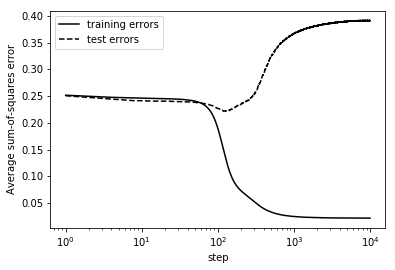

In [10]:
import time
from lib.learn_linear import plot_steps


start_time = time.perf_counter()

plot_steps(learner = nn1, data = data, num_steps=10000)

for eg in data.train:
    print(eg,nn1.predictor(eg))

end_time = time.perf_counter()

print("Time:", end_time - start_time)


In [11]:
from lib.learn_problem import Data_set, Learner


class Boosted_dataset(Data_set):
    
    def __init__(self, base_dataset, offset_fun):
        """new dataset which is like base_dataset,
           but offset_fun(e) is subtracted from the target of each example e
        """
        self.base_dataset = base_dataset
        self.offset_fun = offset_fun
        Data_set.__init__(
            self,
            base_dataset.train,
            base_dataset.test, 
            base_dataset.prob_test,
            base_dataset.target_index
        )

    def create_features(self):
        self.input_features = self.base_dataset.input_features
        def newout(e):
            return self.base_dataset.target(e) - self.offset_fun(e)
        
        newout.frange = self.base_dataset.target.frange
        self.target = newout


In [12]:
class Boosting_learner(Learner):
    
    def __init__(self, dataset, base_learner_class):
        self.dataset = dataset
        self.base_learner_class = base_learner_class
        mean = sum(self.dataset.target(e) for e in self.dataset.train) / len(self.dataset.train)
        self.predictor = lambda e: mean     # function that returns mean for each example
        self.predictor.__doc__ = 'lambda e:' + str(mean)
        self.offsets = [self.predictor]
        self.errors = [data.evaluate_dataset(data.test, self.predictor, 'sum-of-squares')]
        self.display(1, 'Predict mean test set error=', self.errors[0])

    def learn(self, num_ensemble=10):
        """adds num_ensemble learners to the ensemble.
        returns a new predictor.
        """
        for i in range(num_ensemble):
            train_subset = Boosted_dataset(self.dataset, self.predictor)
            learner = self.base_learner_class(train_subset)
            new_offset = learner.learn()
            self.offsets.append(new_offset)
            def new_pred(e, old_pred=self.predictor, off=new_offset):
                return old_pred(e) + off(e)
            self.predictor = new_pred
            self.errors.append(data.evaluate_dataset(data.test, self.predictor, 'sum-of-squares'))
            self.display(1, 'After Iteration', len(self.offsets) - 1, 'test set error=', self.errors[-1])
        return self.predictor


In [13]:
# Testing

from lib.learn_dt import DT_learner
from lib.learn_problem import Data_set, Data_from_file


def sp_DT_learner(min_prop=0.9):
    def make_learner(dataset):
        mne = len(dataset.train) * min_prop
        return DT_learner(dataset, min_number_examples=mne)
    return make_learner


In [14]:
data = Data_from_file('data/carbool.csv', target_index=-1)
#data = Data_from_file('data/SPECT.csv', target_index=0)
#data = Data_from_file('data/mail_reading.csv', target_index=-1)
#data = Data_from_file('data/holiday.csv', num_train=19, target_index=-1)
learner9 = Boosting_learner(data, sp_DT_learner(0.9))
#learner7 = Boosting_learner(data, sp_DT_learner(0.7))
#learner5 = Boosting_learner(data, sp_DT_learner(0.5))
predictor9 =learner9.learn(10)

for i in learner9.offsets:
    print(i.__doc__)


Tuples read. 
Training set 1174 examples. Number of columns: {7} 
Test set 554 examples. Number of columns: {7}
There are 20 input features
Predict mean test set error= 0.19987595710658787
Tuples read. 
Training set 1174 examples. Number of columns: {7} 
Test set 554 examples. Number of columns: {7}
There are 20 input features
   split on e[0]==vhigh has err= 246.00538387398117 splits into 306 : 868
   split on e[0]==med has err= 249.10210627854403 splits into 293 : 881
   split on e[0]==high has err= 251.29888599382167 splits into 283 : 891
   split on e[0]==low has err= 249.25818500916458 splits into 292 : 882
   split on e[1]==vhigh has err= 247.22435001397906 splits into 292 : 882
   split on e[1]==med has err= 250.44315789473677 splits into 300 : 874
   split on e[1]==high has err= 251.57408558637817 splits into 289 : 885
   split on e[1]==low has err= 249.33775224399696 splits into 293 : 881
   split on e[2]<3 has err= 250.55596348210273 splits into 289 : 885
   split on e[2]<4 h

   split on e[5]==med has err= 121.94773665942364 splits into 401 : 773
   split on e[5]==high has err= 121.9371314918973 splits into 383 : 791
   split on e[5]==low has err= 123.98107004901898 splits into 390 : 784
best split is on e[0]==high with err= 120.30801009464048
Splitting on e[0]==high with examples split 283 : 891
After Iteration 6 test set error= 0.10243894000101174
Tuples read. 
Training set 1174 examples. Number of columns: {7} 
Test set 554 examples. Number of columns: {7}
There are 20 input features
   split on e[0]==vhigh has err= 120.01561779694691 splits into 306 : 868
   split on e[0]==med has err= 120.29271113588992 splits into 293 : 881
   split on e[0]==high has err= 120.30801009464048 splits into 283 : 891
   split on e[0]==low has err= 120.12712742274807 splits into 292 : 882
   split on e[1]==vhigh has err= 120.27911017179566 splits into 292 : 882
   split on e[1]==med has err= 119.80137535765722 splits into 300 : 874
   split on e[1]==high has err= 118.123198

Predict mean test set error= 0.19987595710658787
Predict mean test set error= 0.19987595710658787
Predict mean test set error= 0.19987595710658787
Predict mean test set error= 0.19987595710658787
Tuples read. 
Training set 1174 examples. Number of columns: {7} 
Test set 554 examples. Number of columns: {7}
There are 20 input features
   split on e[0]==vhigh has err= 246.00538387398117 splits into 306 : 868
   split on e[0]==med has err= 249.10210627854403 splits into 293 : 881
   split on e[0]==high has err= 251.29888599382167 splits into 283 : 891
   split on e[0]==low has err= 249.25818500916458 splits into 292 : 882
   split on e[1]==vhigh has err= 247.22435001397906 splits into 292 : 882
   split on e[1]==med has err= 250.44315789473677 splits into 300 : 874
   split on e[1]==high has err= 251.57408558637817 splits into 289 : 885
   split on e[1]==low has err= 249.33775224399696 splits into 293 : 881
   split on e[2]<3 has err= 250.55596348210273 splits into 289 : 885
   split on e

   split on e[5]==med has err= 65.22648745234545 splits into 308 : 574
   split on e[5]==high has err= 63.02357403230377 splits into 284 : 598
   split on e[5]==low has err= 65.21188437800575 splits into 290 : 592
best split is on e[4]==small with err= 62.24907883131576
Splitting on e[4]==small with examples split 302 : 580
After Iteration 3 test set error= 0.08251701530553934
Tuples read. 
Training set 1174 examples. Number of columns: {7} 
Test set 554 examples. Number of columns: {7}
There are 20 input features
   split on e[0]==vhigh has err= 92.65853053426306 splits into 306 : 868
   split on e[0]==med has err= 92.62530422534634 splits into 293 : 881
   split on e[0]==high has err= 92.64412684385482 splits into 283 : 891
   split on e[0]==low has err= 92.59340502699482 splits into 292 : 882
   split on e[1]==vhigh has err= 92.66259863486385 splits into 292 : 882
   split on e[1]==med has err= 92.19043768824064 splits into 300 : 874
   split on e[1]==high has err= 90.54746833356887

   split on e[5]==high has err= 84.9649631604164 splits into 383 : 791
   split on e[5]==low has err= 85.04370595972759 splits into 390 : 784
best split is on e[1]==high with err= 84.36809851928228
Splitting on e[1]==high with examples split 289 : 885
   split on e[0]==vhigh has err= 59.62556500299321 splits into 233 : 652
   split on e[0]==med has err= 60.36234397072003 splits into 227 : 658
   split on e[0]==high has err= 59.676438054685576 splits into 213 : 672
   split on e[0]==low has err= 60.371665824192824 splits into 212 : 673
   split on e[1]==vhigh has err= 60.253685539402056 splits into 292 : 593
   split on e[1]==med has err= 60.3217811355572 splits into 300 : 585
   split on e[1]==low has err= 60.36191703142782 splits into 293 : 592
   split on e[2]<3 has err= 60.375308141332795 splits into 211 : 674
   split on e[2]<4 has err= 60.30997815999133 splits into 431 : 454
   split on e[2]<5 has err= 60.37528687958954 splits into 658 : 227
   split on e[3]==2 has err= 60.3321082

   split on e[2]<3 has err= 50.87486178517842 splits into 218 : 650
   split on e[2]<4 has err= 50.81892011973943 splits into 428 : 440
   split on e[2]<5 has err= 50.87659949590389 splits into 653 : 215
   split on e[3]==2 has err= 49.92926136030737 splits into 289 : 579
   split on e[3]==4 has err= 50.409999745490346 splits into 287 : 581
   split on e[3]==more has err= 50.79269348035581 splits into 292 : 576
   split on e[4]==small has err= 50.854928416172726 splits into 284 : 584
   split on e[4]==big has err= 50.87674654039493 splits into 291 : 577
   split on e[4]==med has err= 50.84918429495437 splits into 293 : 575
   split on e[5]==med has err= 50.34125486494579 splits into 297 : 571
   split on e[5]==high has err= 50.86845345543238 splits into 279 : 589
   split on e[5]==low has err= 50.46363305027932 splits into 292 : 576
best split is on e[3]==2 with err= 49.92926136030737
Splitting on e[3]==2 with examples split 289 : 579
After Iteration 8 test set error= 0.070902738133416

   split on e[0]==vhigh has err= 41.96043974458293 splits into 226 : 440
   split on e[0]==med has err= 41.50528503769846 splits into 214 : 452
   split on e[0]==high has err= 41.80592192304686 splits into 226 : 440
   split on e[1]==med has err= 42.01422730647566 splits into 234 : 432
   split on e[1]==high has err= 41.942026111468095 splits into 209 : 457
   split on e[1]==low has err= 41.98191755633133 splits into 223 : 443
   split on e[2]<3 has err= 42.01528413309748 splits into 170 : 496
   split on e[2]<4 has err= 41.95417088116153 splits into 331 : 335
   split on e[2]<5 has err= 41.94219030119275 splits into 506 : 160
   split on e[3]==2 has err= 41.982129477202534 splits into 218 : 448
   split on e[3]==4 has err= 41.87843447773564 splits into 220 : 446
   split on e[3]==more has err= 41.98792003720716 splits into 228 : 438
   split on e[4]==small has err= 42.01089170597584 splits into 228 : 438
   split on e[4]==big has err= 41.99368136848133 splits into 214 : 452
   split o

   split on e[0]==low has err= 24.722106360792488 splits into 126 : 137
   split on e[1]==vhigh has err= 24.25159976730655 splits into 72 : 191
   split on e[1]==med has err= 24.855527638190868 splits into 64 : 199
   split on e[1]==high has err= 24.97769218424009 splits into 62 : 201
   split on e[1]==low has err= 24.524320124320187 splits into 65 : 198
   split on e[2]<3 has err= 22.663285180977176 splits into 61 : 202
   split on e[2]<4 has err= 23.867130434782634 splits into 125 : 138
   split on e[2]<5 has err= 24.81085972850679 splits into 195 : 68
   split on e[3]==4 has err= 24.886941938468595 splits into 131 : 132
   split on e[3]==more has err= 24.886941938468595 splits into 132 : 131
   split on e[4]==small has err= 21.75327868852459 splits into 80 : 183
   split on e[4]==big has err= 23.415204678362628 splits into 92 : 171
   split on e[4]==med has err= 24.7904421160236 splits into 91 : 172
   split on e[5]==med has err= 24.22766303086573 splits into 139 : 124
   split on e

   split on e[1]==low has err= 30.652605450278973 splits into 199 : 399
   split on e[2]<3 has err= 30.039389150658856 splits into 155 : 443
   split on e[2]<4 has err= 30.161747352377613 splits into 303 : 295
   split on e[2]<5 has err= 30.446234765471022 splits into 459 : 139
   split on e[3]==2 has err= 30.641451430862496 splits into 201 : 397
   split on e[3]==4 has err= 30.666355341586325 splits into 194 : 404
   split on e[3]==more has err= 30.66762080046504 splits into 203 : 395
   split on e[4]==small has err= 29.29771642915398 splits into 209 : 389
   split on e[4]==big has err= 29.183830462219042 splits into 192 : 406
   split on e[4]==med has err= 30.675091258459204 splits into 197 : 401
   split on e[5]==med has err= 30.61209825215958 splits into 308 : 290
   split on e[5]==low has err= 30.61209825215958 splits into 290 : 308
best split is on e[4]==big with err= 29.183830462219042
Splitting on e[4]==big with examples split 192 : 406
   split on e[0]==vhigh has err= 3.018807

   split on e[3]==more has err= 0.9315119661075782 splits into 98 : 194
   split on e[4]==small has err= 0.882248120878584 splits into 99 : 193
   split on e[4]==big has err= 0.7741796461964219 splits into 97 : 195
   split on e[4]==med has err= 0.9033281185379886 splits into 96 : 196
best split is on e[0]==high with err= 0.6740439515353828
Splitting on e[0]==high with examples split 96 : 196
   split on e[0]==med has err= 0.16876986284845613 splits into 97 : 99
   split on e[0]==low has err= 0.16876986284845613 splits into 99 : 97
   split on e[1]==vhigh has err= 0.15851673792606435 splits into 51 : 145
   split on e[1]==med has err= 0.1680279607517402 splits into 47 : 149
   split on e[1]==high has err= 0.16724525355122524 splits into 48 : 148
   split on e[1]==low has err= 0.1675863363584188 splits into 50 : 146
   split on e[2]<3 has err= 0.09173422333684234 splits into 54 : 142
   split on e[2]<4 has err= 0.14289369404392782 splits into 104 : 92
   split on e[2]<5 has err= 0.15983

   split on e[2]<5 has err= 3.7923416190815615 splits into 99 : 29
   split on e[3]==2 has err= 3.7198987698708366 splits into 45 : 83
   split on e[3]==4 has err= 3.7556557790858367 splits into 40 : 88
   split on e[3]==more has err= 3.7866105633804183 splits into 43 : 85
   split on e[4]==big has err= 3.780359913385841 splits into 65 : 63
   split on e[4]==med has err= 3.780359913385841 splits into 63 : 65
   split on e[5]==med has err= 3.793548131769457 splits into 67 : 61
   split on e[5]==high has err= 3.793548131769457 splits into 61 : 67
best split is on e[0]==high with err= 3.41380239342951
Splitting on e[0]==high with examples split 30 : 98
   split on e[0]==vhigh has err= 15.400960909030271 splits into 104 : 292
   split on e[0]==med has err= 15.376019441916624 splits into 102 : 294
   split on e[0]==high has err= 15.583946596113655 splits into 92 : 304
   split on e[0]==low has err= 15.595352812815072 splits into 98 : 298
   split on e[1]==vhigh has err= 15.48442088575478 sp

   split on e[2]<3 has err= 33.650771894280126 splits into 216 : 666
   split on e[2]<4 has err= 33.90767751543609 splits into 438 : 444
   split on e[2]<5 has err= 34.12332276741193 splits into 666 : 216
   split on e[3]==2 has err= 33.94785063950238 splits into 288 : 594
   split on e[3]==4 has err= 33.837420083326194 splits into 289 : 593
   split on e[3]==more has err= 34.22966281356362 splits into 305 : 577
   split on e[4]==small has err= 34.23456831472793 splits into 301 : 581
   split on e[4]==big has err= 34.238379983441526 splits into 286 : 596
   split on e[4]==med has err= 34.23406946679129 splits into 295 : 587
   split on e[5]==med has err= 34.21839284653446 splits into 300 : 582
   split on e[5]==high has err= 34.22929028269755 splits into 291 : 591
   split on e[5]==low has err= 34.18179468927592 splits into 291 : 591
best split is on e[2]<3 with err= 33.650771894280126
Splitting on e[2]<3 with examples split 216 : 666
   split on e[0]==vhigh has err= 12.402131212616517

   split on e[0]==med has err= 36.17098060975157 splits into 293 : 881
   split on e[0]==high has err= 36.26219553870212 splits into 283 : 891
   split on e[0]==low has err= 36.264566077696 splits into 292 : 882
   split on e[1]==vhigh has err= 36.26416223289031 splits into 292 : 882
   split on e[1]==med has err= 36.258136241566135 splits into 300 : 874
   split on e[1]==high has err= 36.25847816464359 splits into 289 : 885
   split on e[1]==low has err= 36.26427966114112 splits into 293 : 881
   split on e[2]<3 has err= 36.25069416513925 splits into 289 : 885
   split on e[2]<4 has err= 36.26452802963211 splits into 579 : 595
   split on e[2]<5 has err= 36.26418126281188 splits into 882 : 292
   split on e[3]==2 has err= 36.186505875524304 splits into 390 : 784
   split on e[3]==4 has err= 36.24344952626758 splits into 384 : 790
   split on e[3]==more has err= 36.24666069215165 splits into 400 : 774
   split on e[4]==small has err= 36.151708999816364 splits into 394 : 780
   split on

   split on e[0]==low has err= 0.6365327324545369 splits into 35 : 103
   split on e[1]==vhigh has err= 0.6569693255187812 splits into 32 : 106
   split on e[1]==med has err= 0.6552142605770372 splits into 34 : 104
   split on e[1]==high has err= 0.6558534726537709 splits into 35 : 103
   split on e[1]==low has err= 0.656951829449708 splits into 37 : 101
   split on e[2]<3 has err= 0.6487191505266834 splits into 69 : 69
   split on e[3]==2 has err= 0.6048114130211282 splits into 44 : 94
   split on e[3]==4 has err= 0.5765954598237704 splits into 48 : 90
   split on e[3]==more has err= 0.653298817120332 splits into 46 : 92
   split on e[4]==small has err= 0.6547073149900624 splits into 67 : 71
   split on e[4]==med has err= 0.6547073149900624 splits into 71 : 67
best split is on e[3]==4 with err= 0.5765954598237704
Splitting on e[3]==4 with examples split 48 : 90
   split on e[0]==vhigh has err= 0.6051208859477895 splits into 35 : 94
   split on e[0]==med has err= 0.6273668611539123 spl

   split on e[1]==high has err= 32.061338173085396 splits into 289 : 885
   split on e[1]==low has err= 32.061327542316725 splits into 293 : 881
   split on e[2]<3 has err= 32.03405816667693 splits into 289 : 885
   split on e[2]<4 has err= 32.03456836710328 splits into 579 : 595
   split on e[2]<5 has err= 32.05364316257752 splits into 882 : 292
   split on e[3]==2 has err= 32.05544596328909 splits into 390 : 784
   split on e[3]==4 has err= 32.04991417206493 splits into 384 : 790
   split on e[3]==more has err= 32.06047201148357 splits into 400 : 774
   split on e[4]==small has err= 32.05962508633755 splits into 394 : 780
   split on e[4]==big has err= 32.061342781967674 splits into 386 : 788
   split on e[4]==med has err= 32.0596250863376 splits into 394 : 780
   split on e[5]==med has err= 32.01304503736385 splits into 401 : 773
   split on e[5]==high has err= 31.992652865582194 splits into 383 : 791
   split on e[5]==low has err= 32.059774191035785 splits into 390 : 784
best split

   split on e[5]==low has err= 10.682199285168606 splits into 126 : 132
best split is on e[5]==med with err= 10.682199285168606
Splitting on e[5]==med with examples split 132 : 126
   split on e[0]==vhigh has err= 10.101843158224526 splits into 31 : 101
   split on e[0]==med has err= 10.019628931250518 splits into 33 : 99
   split on e[0]==high has err= 10.092059658760105 splits into 34 : 98
   split on e[0]==low has err= 9.999290240607193 splits into 34 : 98
   split on e[1]==vhigh has err= 9.915954646335077 splits into 30 : 102
   split on e[1]==med has err= 10.09863049619969 splits into 34 : 98
   split on e[1]==high has err= 10.093352684357086 splits into 34 : 98
   split on e[1]==low has err= 10.121067005539917 splits into 34 : 98
   split on e[2]<3 has err= 10.128044028994937 splits into 34 : 98
   split on e[2]<4 has err= 9.92675343543996 splits into 69 : 63
   split on e[2]<5 has err= 10.080477167600439 splits into 102 : 30
   split on e[4]==small has err= 10.02297945262274 spl

   split on e[1]==vhigh has err= 29.227564975278497 splits into 292 : 882
   split on e[1]==med has err= 29.228943456495944 splits into 300 : 874
   split on e[1]==high has err= 29.219457585137878 splits into 289 : 885
   split on e[1]==low has err= 29.216793600200074 splits into 293 : 881
   split on e[2]<3 has err= 29.189622271510444 splits into 289 : 885
   split on e[2]<4 has err= 29.228629915794528 splits into 579 : 595
   split on e[2]<5 has err= 29.229909275350938 splits into 882 : 292
   split on e[3]==2 has err= 29.22279965713671 splits into 390 : 784
   split on e[3]==4 has err= 29.221396237171607 splits into 384 : 790
   split on e[3]==more has err= 29.23125256418009 splits into 400 : 774
   split on e[4]==small has err= 29.231294706905615 splits into 394 : 780
   split on e[4]==big has err= 29.218221085568516 splits into 386 : 788
   split on e[4]==med has err= 29.218872479627336 splits into 394 : 780
   split on e[5]==med has err= 29.225142721943605 splits into 401 : 773
 

   split on e[0]==vhigh has err= 15.701652324660554 splits into 235 : 431
   split on e[0]==med has err= 15.701799610861933 splits into 220 : 446
   split on e[0]==high has err= 15.70208386791994 splits into 211 : 455
   split on e[1]==vhigh has err= 15.700052492736651 splits into 170 : 496
   split on e[1]==med has err= 15.69077769846417 splits into 180 : 486
   split on e[1]==high has err= 15.699788860396959 splits into 153 : 513
   split on e[1]==low has err= 15.701813852911362 splits into 163 : 503
   split on e[2]<4 has err= 15.662108499615634 splits into 222 : 444
   split on e[2]<5 has err= 15.699080575610434 splits into 450 : 216
   split on e[3]==2 has err= 15.69968204506728 splits into 217 : 449
   split on e[3]==4 has err= 15.70130603974112 splits into 218 : 448
   split on e[3]==more has err= 15.696288788000794 splits into 231 : 435
   split on e[4]==small has err= 15.701975455168359 splits into 227 : 439
   split on e[4]==big has err= 15.695546265343332 splits into 214 : 4

   split on e[1]==low has err= 1.7874111140787707 splits into 46 : 93
   split on e[2]<5 has err= 1.8154660021422568 splits into 74 : 65
   split on e[3]==2 has err= 1.8135159970150805 splits into 70 : 69
   split on e[3]==4 has err= 1.8135159970150805 splits into 69 : 70
   split on e[4]==big has err= 1.8051692257825294 splits into 70 : 69
   split on e[4]==med has err= 1.8051692257825294 splits into 69 : 70
   split on e[5]==med has err= 1.6950304941871113 splits into 43 : 96
   split on e[5]==high has err= 1.7844966719549444 splits into 47 : 92
   split on e[5]==low has err= 1.7902240541183112 splits into 49 : 90
best split is on e[5]==med with err= 1.6950304941871113
Splitting on e[5]==med with examples split 43 : 96
After Iteration 7 test set error= 0.036042487056163135
Tuples read. 
Training set 1174 examples. Number of columns: {7} 
Test set 554 examples. Number of columns: {7}
There are 20 input features
   split on e[0]==vhigh has err= 28.05740232944214 splits into 306 : 868
 

   split on e[2]<4 has err= 16.321966057748615 splits into 318 : 340
   split on e[2]<5 has err= 16.328027915588653 splits into 487 : 171
   split on e[3]==2 has err= 16.325446357216652 splits into 221 : 437
   split on e[3]==4 has err= 16.3353665610418 splits into 214 : 444
   split on e[3]==more has err= 16.322755791661777 splits into 223 : 435
   split on e[4]==small has err= 16.295547784321755 splits into 220 : 438
   split on e[4]==big has err= 16.303577014932415 splits into 221 : 437
   split on e[4]==med has err= 16.335090470531924 splits into 217 : 441
   split on e[5]==med has err= 16.322201849941578 splits into 221 : 437
   split on e[5]==high has err= 16.33553362768929 splits into 219 : 439
   split on e[5]==low has err= 16.322324550366375 splits into 218 : 440
best split is on e[4]==small with err= 16.295547784321755
Splitting on e[4]==small with examples split 220 : 438
   split on e[0]==vhigh has err= 8.222283058029303 splits into 82 : 138
   split on e[0]==high has err= 

   split on e[1]==med has err= 26.445322061437352 splits into 300 : 874
   split on e[1]==high has err= 26.445369668351745 splits into 289 : 885
   split on e[1]==low has err= 26.440564177442578 splits into 293 : 881
   split on e[2]<3 has err= 26.43860901579336 splits into 289 : 885
   split on e[2]<4 has err= 26.444878667912693 splits into 579 : 595
   split on e[2]<5 has err= 26.44341545421736 splits into 882 : 292
   split on e[3]==2 has err= 26.42482045696202 splits into 390 : 784
   split on e[3]==4 has err= 26.44500541312005 splits into 384 : 790
   split on e[3]==more has err= 26.41933573162804 splits into 400 : 774
   split on e[4]==small has err= 26.445341758886535 splits into 394 : 780
   split on e[4]==big has err= 26.445347205786753 splits into 386 : 788
   split on e[4]==med has err= 26.445269707503915 splits into 394 : 780
   split on e[5]==med has err= 26.44009391468303 splits into 401 : 773
   split on e[5]==high has err= 26.42776939468427 splits into 383 : 791
   spli

   split on e[0]==low has err= 12.769924126847375 splits into 216 : 440
   split on e[1]==med has err= 12.765106927275118 splits into 221 : 435
   split on e[1]==high has err= 12.769569929077672 splits into 219 : 437
   split on e[1]==low has err= 12.767333966888021 splits into 216 : 440
   split on e[2]<3 has err= 12.768898803735151 splits into 161 : 495
   split on e[2]<4 has err= 12.769571834610872 splits into 323 : 333
   split on e[2]<5 has err= 12.76857482558853 splits into 494 : 162
   split on e[3]==2 has err= 12.713677426386361 splits into 220 : 436
   split on e[3]==4 has err= 12.737281068251395 splits into 214 : 442
   split on e[3]==more has err= 12.766604949609185 splits into 222 : 434
   split on e[4]==small has err= 12.749068642131434 splits into 224 : 432
   split on e[4]==big has err= 12.747870563785918 splits into 211 : 445
   split on e[4]==med has err= 12.769921481885147 splits into 221 : 435
   split on e[5]==med has err= 12.761139565833783 splits into 233 : 423
  

   split on e[0]==high has err= 24.271228004352288 splits into 283 : 891
   split on e[0]==low has err= 24.267185533423817 splits into 292 : 882
   split on e[1]==vhigh has err= 24.26454026778957 splits into 292 : 882
   split on e[1]==med has err= 24.266291712602843 splits into 300 : 874
   split on e[1]==high has err= 24.26809029132131 splits into 289 : 885
   split on e[1]==low has err= 24.26921355603583 splits into 293 : 881
   split on e[2]<3 has err= 24.254955283329174 splits into 289 : 885
   split on e[2]<4 has err= 24.249393392999664 splits into 579 : 595
   split on e[2]<5 has err= 24.247614970915524 splits into 882 : 292
   split on e[3]==2 has err= 24.271228004352295 splits into 390 : 784
   split on e[3]==4 has err= 24.266919169115244 splits into 384 : 790
   split on e[3]==more has err= 24.267006013856445 splits into 400 : 774
   split on e[4]==small has err= 24.270687177492274 splits into 394 : 780
   split on e[4]==big has err= 24.271095289688816 splits into 386 : 788
 

   split on e[2]<3 has err= 12.242027887551194 splits into 155 : 443
   split on e[2]<4 has err= 12.240469215210068 splits into 303 : 295
   split on e[2]<5 has err= 12.229956122353434 splits into 459 : 139
   split on e[3]==2 has err= 12.231942326544074 splits into 201 : 397
   split on e[3]==4 has err= 12.223230531540565 splits into 194 : 404
   split on e[3]==more has err= 12.242705820483256 splits into 203 : 395
   split on e[4]==small has err= 12.232725803197729 splits into 209 : 389
   split on e[4]==big has err= 12.234121977220514 splits into 192 : 406
   split on e[4]==med has err= 12.243723716914392 splits into 197 : 401
   split on e[5]==med has err= 12.164274294964502 splits into 308 : 290
   split on e[5]==low has err= 12.164274294964502 splits into 290 : 308
best split is on e[5]==med with err= 12.164274294964502
Splitting on e[5]==med with examples split 308 : 290
   split on e[0]==vhigh has err= 11.200805328424925 splits into 78 : 230
   split on e[0]==med has err= 11.19

Splitting on e[4]==small with examples split 21 : 52
   split on e[1]==med has err= 5.227272727272727 splits into 10 : 11
   split on e[1]==low has err= 5.227272727272727 splits into 11 : 10
   split on e[2]<3 has err= 5.199999999999999 splits into 5 : 16
   split on e[2]<4 has err= 4.945454545454545 splits into 11 : 10
   split on e[2]<5 has err= 4.933333333333334 splits into 15 : 6
   split on e[3]==4 has err= 4.945454545454545 splits into 10 : 11
   split on e[3]==more has err= 4.945454545454545 splits into 11 : 10
   split on e[5]==med has err= 0.9090909090909085 splits into 10 : 11
   split on e[5]==high has err= 0.9090909090909085 splits into 11 : 10
best split is on e[5]==med with err= 0.9090909090909085
Splitting on e[5]==med with examples split 10 : 11
   split on e[1]==med has err= 3.6369047619047623 splits into 28 : 24
   split on e[1]==low has err= 3.6369047619047623 splits into 24 : 28
   split on e[2]<3 has err= 3.2249999999999988 splits into 12 : 40
   split on e[2]<4 ha

   split on e[1]==vhigh has err= 2.692307692307693 splits into 4 : 13
   split on e[1]==med has err= 2.8571428571428577 splits into 3 : 14
   split on e[1]==high has err= 2.9696969696969697 splits into 6 : 11
   split on e[1]==low has err= 2.769230769230769 splits into 4 : 13
   split on e[3]==4 has err= 3.0555555555555554 splits into 8 : 9
   split on e[3]==more has err= 3.0555555555555554 splits into 9 : 8
   split on e[5]==med has err= 2.5454545454545454 splits into 11 : 6
   split on e[5]==high has err= 2.5454545454545454 splits into 6 : 11
best split is on e[0]==med with err= 2.2222222222222223
Splitting on e[0]==med with examples split 9 : 8
   split on e[0]==med has err= 1.9722007722007746 splits into 74 : 70
   split on e[0]==low has err= 1.9722007722007746 splits into 70 : 74
   split on e[1]==vhigh has err= 1.902439024390244 splits into 41 : 103
   split on e[1]==med has err= 1.9639639639639623 splits into 33 : 111
   split on e[1]==high has err= 1.9642857142857082 splits int

   split on e[0]==high has err= 1.3468425123479686 splits into 23 : 59
   split on e[0]==low has err= 1.353406221303943 splits into 18 : 64
   split on e[1]==vhigh has err= 1.3605015673981142 splits into 24 : 58
   split on e[1]==med has err= 1.3607363823459169 splits into 21 : 61
   split on e[1]==high has err= 1.369743926872021 splits into 22 : 60
   split on e[1]==low has err= 1.369499609391056 splits into 15 : 67
   split on e[2]<3 has err= 1.2055318581711503 splits into 20 : 62
   split on e[2]<4 has err= 1.2986250713523404 splits into 37 : 45
   split on e[2]<5 has err= 1.3373558880265266 splits into 61 : 21
   split on e[3]==2 has err= 1.3482880755608044 splits into 40 : 42
   split on e[3]==more has err= 1.3482880755608044 splits into 42 : 40
best split is on e[2]<3 with err= 1.2055318581711503
Splitting on e[2]<3 with examples split 20 : 62
   split on e[0]==vhigh has err= 1.0944903581267167 splits into 5 : 15
   split on e[0]==med has err= 1.0661157024793326 splits into 6 : 1

   split on e[1]==low has err= 8.431344239208972 splits into 199 : 592
   split on e[2]<3 has err= 8.39412795889234 splits into 201 : 590
   split on e[2]<4 has err= 8.429447433167558 splits into 403 : 388
   split on e[2]<5 has err= 8.446725169565276 splits into 604 : 187
   split on e[3]==2 has err= 8.442234204287757 splits into 263 : 528
   split on e[3]==4 has err= 8.380071295692607 splits into 258 : 533
   split on e[3]==more has err= 8.444563704344478 splits into 270 : 521
   split on e[4]==small has err= 8.464079929386006 splits into 265 : 526
   split on e[4]==big has err= 8.417690054255134 splits into 261 : 530
   split on e[4]==med has err= 8.418898081981197 splits into 265 : 526
   split on e[5]==med has err= 8.421421609173663 splits into 401 : 390
   split on e[5]==low has err= 8.421421609173663 splits into 390 : 401
best split is on e[3]==4 with err= 8.380071295692607
Splitting on e[3]==4 with examples split 258 : 533
   split on e[0]==vhigh has err= 5.196322393579706 spli

   split on e[2]<3 has err= 0.07619047619047659 splits into 6 : 15
   split on e[2]<4 has err= 0.07421150278293168 splits into 11 : 10
   split on e[2]<5 has err= 0.07683073229291754 splits into 17 : 4
   split on e[5]==med has err= 0.07421150278293145 splits into 11 : 10
   split on e[5]==low has err= 0.07421150278293145 splits into 10 : 11
best split is on e[1]==vhigh with err= 0.0653061224489801
Splitting on e[1]==vhigh with examples split 5 : 16
   split on e[1]==med has err= 3.566458081161131e-30 splits into 5 : 11
   split on e[1]==high has err= 3.80695820778533e-30 splits into 7 : 9
   split on e[1]==low has err= 3.644373036099153e-30 splits into 4 : 12
   split on e[2]<3 has err= 3.817459278276908e-30 splits into 5 : 11
   split on e[2]<4 has err= 3.814882033842237e-30 splits into 8 : 8
   split on e[2]<5 has err= 3.6579631879118546e-30 splits into 13 : 3
   split on e[5]==med has err= 7.0997481469891055e-31 splits into 10 : 6
   split on e[5]==low has err= 7.0997481469891055e-

   split on e[4]==small has err= 1.1681566624095425 splits into 31 : 58
   split on e[4]==big has err= 1.1702084598259515 splits into 28 : 61
   split on e[4]==med has err= 1.1292181069958909 splits into 30 : 59
   split on e[5]==med has err= 1.1493827160493881 splits into 40 : 49
   split on e[5]==low has err= 1.1493827160493881 splits into 49 : 40
best split is on e[4]==med with err= 1.1292181069958909
Splitting on e[4]==med with examples split 30 : 59
   split on e[1]==vhigh has err= 1.1130864197530925 splits into 5 : 25
   split on e[1]==med has err= 1.094650205761323 splits into 9 : 21
   split on e[1]==high has err= 1.0838477366255206 splits into 6 : 24
   split on e[1]==low has err= 1.1191358024691413 splits into 10 : 20
   split on e[2]<4 has err= 1.0237416904083632 splits into 13 : 17
   split on e[2]<5 has err= 1.0998877665544389 splits into 22 : 8
   split on e[3]==2 has err= 1.0237416904083585 splits into 17 : 13
   split on e[3]==more has err= 1.0237416904083585 splits int

   split on e[4]==big has err= 0.8636827393431108 splits into 98 : 212
   split on e[4]==med has err= 0.8636617749825305 splits into 106 : 204
   split on e[5]==med has err= 0.8636755743084876 splits into 158 : 152
   split on e[5]==low has err= 0.8636755743084876 splits into 152 : 158
best split is on e[1]==vhigh with err= 0.8595983424384497
Splitting on e[1]==vhigh with examples split 105 : 205
   split on e[0]==vhigh has err= 0.30403537866224284 splits into 38 : 67
   split on e[0]==med has err= 0.2992891881780757 splits into 33 : 72
   split on e[0]==low has err= 0.30429490523387054 splits into 34 : 71
   split on e[2]<3 has err= 0.2972107910379497 splits into 27 : 78
   split on e[2]<4 has err= 0.30281854181225093 splits into 53 : 52
   split on e[2]<5 has err= 0.3047351148616948 splits into 79 : 26
   split on e[3]==2 has err= 0.3029263831732961 splits into 51 : 54
   split on e[3]==more has err= 0.3029263831732961 splits into 54 : 51
   split on e[4]==small has err= 0.3045808966

   split on e[2]<5 has err= 2.3240257457761127e-30 splits into 19 : 10
   split on e[4]==small has err= 2.2008671435593158e-30 splits into 9 : 20
   split on e[4]==big has err= 2.2988522339016356e-30 splits into 11 : 18
   split on e[4]==med has err= 2.292900915835101e-30 splits into 9 : 20
best split is on e[0]==vhigh with err= 2.0053375174788947e-30
Splitting on e[0]==vhigh with examples split 16 : 13
   split on e[1]==med has err= 7.76339303550837e-31 splits into 9 : 7
   split on e[1]==low has err= 7.76339303550837e-31 splits into 7 : 9
   split on e[2]<4 has err= 4.141519752410312e-31 splits into 6 : 10
   split on e[2]<5 has err= 7.386606657978566e-31 splits into 11 : 5
   split on e[4]==small has err= 5.02002394231553e-31 splits into 5 : 11
   split on e[4]==big has err= 6.771056103147018e-31 splits into 6 : 10
   split on e[4]==med has err= 7.3866066579785645e-31 splits into 5 : 11
best split is on e[2]<4 with err= 4.141519752410312e-31
Splitting on e[2]<4 with examples split 6

   split on e[5]==high has err= 0.516268611687201 splits into 75 : 152
   split on e[5]==low has err= 0.5166864651397323 splits into 75 : 152
best split is on e[3]==4 with err= 0.5115977422423025
Splitting on e[3]==4 with examples split 72 : 155
   split on e[1]==vhigh has err= 0.4312025085511878 splits into 23 : 49
   split on e[1]==high has err= 0.4261271080164285 splits into 23 : 49
   split on e[1]==low has err= 0.42364129462103717 splits into 26 : 46
   split on e[2]<3 has err= 0.4314051175994996 splits into 19 : 53
   split on e[2]<4 has err= 0.43150700755930543 splits into 39 : 33
   split on e[2]<5 has err= 0.4314647900837576 splits into 52 : 20
   split on e[4]==small has err= 0.4249216988883638 splits into 29 : 43
   split on e[4]==big has err= 0.43151457202760146 splits into 22 : 50
   split on e[4]==med has err= 0.4232136534812849 splits into 21 : 51
   split on e[5]==med has err= 0.4298563110383683 splits into 22 : 50
   split on e[5]==high has err= 0.4214146295386276 spli

   split on e[1]==vhigh has err= 0.008097495292085819 splits into 42 : 40
   split on e[1]==high has err= 0.008097495292085819 splits into 40 : 42
   split on e[2]<4 has err= 0.008147504886798648 splits into 28 : 54
   split on e[2]<5 has err= 0.00817775935473285 splits into 58 : 24
   split on e[3]==2 has err= 0.007524476037056002 splits into 41 : 41
   split on e[3]==more has err= 0.007524476037056002 splits into 41 : 41
   split on e[4]==small has err= 0.006179340491628384 splits into 29 : 53
   split on e[4]==big has err= 0.00776607136448723 splits into 23 : 59
   split on e[4]==med has err= 0.007559592923980606 splits into 30 : 52
   split on e[5]==med has err= 0.008024154057617604 splits into 29 : 53
   split on e[5]==high has err= 0.0073470481434418115 splits into 26 : 56
   split on e[5]==low has err= 0.007955799600632607 splits into 27 : 55
best split is on e[4]==small with err= 0.006179340491628384
Splitting on e[4]==small with examples split 29 : 53
   split on e[1]==vhigh h

   split on e[0]==low has err= 0.16821057102024312 splits into 25 : 24
   split on e[2]<3 has err= 0.16926941856126299 splits into 24 : 25
   split on e[3]==2 has err= 0.17006739276890334 splits into 13 : 36
   split on e[3]==4 has err= 0.16969839605842857 splits into 18 : 31
   split on e[3]==more has err= 0.17005805357758896 splits into 18 : 31
   split on e[4]==small has err= 0.16849384418005542 splits into 14 : 35
   split on e[4]==big has err= 0.16910479927367722 splits into 18 : 31
   split on e[4]==med has err= 0.17016656534414326 splits into 17 : 32
   split on e[5]==high has err= 0.16778950685573793 splits into 24 : 25
   split on e[5]==low has err= 0.16778950685573793 splits into 25 : 24
best split is on e[5]==high with err= 0.16778950685573793
Splitting on e[5]==high with examples split 24 : 25
   split on e[0]==med has err= 0.14227666998754476 splits into 12 : 12
   split on e[0]==low has err= 0.14227666998754476 splits into 12 : 12
   split on e[2]<3 has err= 0.14298149729

   split on e[2]<5 has err= 1.1754160791141626 splits into 172 : 54
   split on e[3]==2 has err= 1.1726177051701132 splits into 76 : 150
   split on e[3]==4 has err= 1.175287803715313 splits into 77 : 149
   split on e[3]==more has err= 1.1737175908156945 splits into 73 : 153
   split on e[4]==small has err= 1.1723938722045202 splits into 78 : 148
   split on e[4]==big has err= 1.1746080671897214 splits into 73 : 153
   split on e[4]==med has err= 1.174695854528389 splits into 75 : 151
   split on e[5]==med has err= 1.155945013417849 splits into 75 : 151
   split on e[5]==high has err= 1.1611334829451188 splits into 75 : 151
   split on e[5]==low has err= 1.1750343138107149 splits into 76 : 150
best split is on e[5]==med with err= 1.155945013417849
Splitting on e[5]==med with examples split 75 : 151
   split on e[1]==med has err= 0.6008419844441926 splits into 27 : 48
   split on e[1]==high has err= 0.6009524238609805 splits into 21 : 54
   split on e[1]==low has err= 0.605268986490724

   split on e[1]==med has err= 2.1878564168239e-31 splits into 9 : 16
   split on e[1]==high has err= 2.2851923048068995e-31 splits into 7 : 18
   split on e[1]==low has err= 2.2152474204774076e-31 splits into 9 : 16
   split on e[2]<4 has err= 2.189669056771559e-31 splits into 8 : 17
   split on e[2]<5 has err= 2.2186712959340953e-31 splits into 18 : 7
   split on e[3]==2 has err= 2.0214560696288426e-31 splits into 15 : 10
   split on e[3]==4 has err= 2.0214560696288426e-31 splits into 10 : 15
   split on e[5]==high has err= 2.0954117794933126e-31 splits into 12 : 13
   split on e[5]==low has err= 2.0954117794933126e-31 splits into 13 : 12
best split is on e[3]==2 with err= 2.0214560696288426e-31
Splitting on e[3]==2 with examples split 15 : 10
   split on e[1]==med has err= 0.10145885880676848 splits into 23 : 46
   split on e[1]==high has err= 0.09713508507793646 splits into 24 : 45
   split on e[1]==low has err= 0.09833232667752048 splits into 22 : 47
   split on e[2]<3 has err= 0.

   split on e[2]<5 has err= 0.0007531361701160087 splits into 25 : 12
   split on e[5]==med has err= 0.0007517287484504072 splits into 15 : 22
   split on e[5]==high has err= 0.0007348282692204726 splits into 8 : 29
   split on e[5]==low has err= 0.0007296789709491394 splits into 14 : 23
best split is on e[1]==high with err= 0.0006304739587986303
Splitting on e[1]==high with examples split 13 : 24
   split on e[0]==med has err= 0.0005122600915238872 splits into 5 : 8
   split on e[0]==low has err= 0.0005122600915238872 splits into 8 : 5
   split on e[2]<4 has err= 0.0005122600915238872 splits into 5 : 8
   split on e[2]<5 has err= 0.0006192655328644325 splits into 10 : 3
   split on e[5]==med has err= 0.0006298901866145575 splits into 4 : 9
   split on e[5]==high has err= 0.0005464107642921464 splits into 4 : 9
   split on e[5]==low has err= 0.0005669011679531018 splits into 5 : 8
best split is on e[0]==med with err= 0.0005122600915238872
Splitting on e[0]==med with examples split 5 : 

   split on e[0]==low has err= 0.1511163624662244 splits into 13 : 9
   split on e[2]<4 has err= 0.2430422214344068 splits into 8 : 14
   split on e[2]<5 has err= 0.24327947248941234 splits into 17 : 5
   split on e[3]==4 has err= 0.24101081437970895 splits into 10 : 12
   split on e[3]==more has err= 0.24101081437970895 splits into 12 : 10
   split on e[4]==small has err= 0.19750072656213868 splits into 9 : 13
   split on e[4]==big has err= 0.21093961329874078 splits into 8 : 14
   split on e[4]==med has err= 0.2425552103783116 splits into 5 : 17
best split is on e[0]==med with err= 0.1511163624662244
Splitting on e[0]==med with examples split 9 : 13
   split on e[2]<4 has err= 0.00040980807321901327 splits into 5 : 8
   split on e[2]<5 has err= 0.00042802176536207894 splits into 10 : 3
   split on e[3]==4 has err= 0.00040980807321900926 splits into 5 : 8
   split on e[3]==more has err= 0.00040980807321900926 splits into 8 : 5
   split on e[4]==small has err= 0.00032784645857520403 sp

   split on e[0]==vhigh has err= 4.485831557114924 splits into 306 : 868
   split on e[0]==med has err= 4.485685676673958 splits into 293 : 881
   split on e[0]==high has err= 4.485438727372559 splits into 283 : 891
   split on e[0]==low has err= 4.484826458012737 splits into 292 : 882
   split on e[1]==vhigh has err= 4.485780761459096 splits into 292 : 882
   split on e[1]==med has err= 4.48468311390259 splits into 300 : 874
   split on e[1]==high has err= 4.482950022567184 splits into 289 : 885
   split on e[1]==low has err= 4.4851347290139145 splits into 293 : 881
   split on e[2]<3 has err= 4.485824767530232 splits into 289 : 885
   split on e[2]<4 has err= 4.484308086290831 splits into 579 : 595
   split on e[2]<5 has err= 4.485806869517833 splits into 882 : 292
   split on e[3]==2 has err= 4.484841262925634 splits into 390 : 784
   split on e[3]==4 has err= 4.485755587034537 splits into 384 : 790
   split on e[3]==more has err= 4.484239469463748 splits into 400 : 774
   split on 

   split on e[0]==vhigh has err= 0.01302815693578195 splits into 3 : 10
   split on e[0]==high has err= 0.013949892313442269 splits into 5 : 8
   split on e[0]==low has err= 0.014488622222740232 splits into 5 : 8
   split on e[3]==2 has err= 0.01297262381211566 splits into 4 : 9
   split on e[3]==4 has err= 0.01211438779330252 splits into 4 : 9
   split on e[3]==more has err= 0.014488622222740234 splits into 5 : 8
   split on e[5]==high has err= 0.013719088546953211 splits into 7 : 6
   split on e[5]==low has err= 0.013719088546953211 splits into 6 : 7
best split is on e[3]==4 with err= 0.01211438779330252
Splitting on e[3]==4 with examples split 4 : 9
   split on e[0]==vhigh has err= 0.133920221422213 splits into 7 : 16
   split on e[0]==high has err= 0.13692538932686654 splits into 7 : 16
   split on e[0]==low has err= 0.14071935478565048 splits into 9 : 14
   split on e[3]==2 has err= 0.12934043941919396 splits into 8 : 15
   split on e[3]==4 has err= 0.13717966926200786 splits into

   split on e[0]==vhigh has err= 3.3348632165249144 splits into 233 : 652
   split on e[0]==med has err= 3.335018137732414 splits into 227 : 658
   split on e[0]==high has err= 3.3347488995786287 splits into 213 : 672
   split on e[0]==low has err= 3.332775455133033 splits into 212 : 673
   split on e[1]==vhigh has err= 3.334455556343835 splits into 292 : 593
   split on e[1]==med has err= 3.3348585538011513 splits into 300 : 585
   split on e[1]==low has err= 3.335058827296656 splits into 293 : 592
   split on e[2]<3 has err= 3.3350987802545693 splits into 211 : 674
   split on e[2]<4 has err= 3.3343046839720287 splits into 431 : 454
   split on e[2]<5 has err= 3.3351030675705062 splits into 658 : 227
   split on e[3]==2 has err= 3.333561582103491 splits into 291 : 594
   split on e[3]==4 has err= 3.334631750487075 splits into 286 : 599
   split on e[3]==more has err= 3.331367884882141 splits into 308 : 577
   split on e[4]==small has err= 3.3349372293155746 splits into 292 : 593
   s

   split on e[1]==vhigh has err= 0.11174700084801897 splits into 9 : 18
   split on e[1]==med has err= 0.11168889131412327 splits into 10 : 17
   split on e[1]==low has err= 0.11168924468882749 splits into 8 : 19
   split on e[3]==2 has err= 0.10328538696471296 splits into 7 : 20
   split on e[3]==4 has err= 0.10636774149416298 splits into 9 : 18
   split on e[3]==more has err= 0.0885184406509242 splits into 11 : 16
best split is on e[0]==high with err= 0.08270454229077923
Splitting on e[0]==high with examples split 7 : 20
   split on e[0]==vhigh has err= 0.002181242546802803 splits into 7 : 13
   split on e[0]==med has err= 0.00252138428940542 splits into 6 : 14
   split on e[0]==low has err= 0.0021871011211958553 splits into 7 : 13
   split on e[1]==vhigh has err= 0.002476518066341005 splits into 7 : 13
   split on e[1]==med has err= 0.002521392052805056 splits into 7 : 13
   split on e[1]==low has err= 0.002474798301122888 splits into 6 : 14
   split on e[3]==2 has err= 0.0024438338

   split on e[3]==more has err= 0.0015075246682239544 splits into 25 : 51
   split on e[4]==small has err= 0.001494620028482856 splits into 37 : 39
   split on e[4]==big has err= 0.001494620028482856 splits into 39 : 37
best split is on e[1]==low with err= 0.0013733567375941494
Splitting on e[1]==low with examples split 26 : 50
   split on e[0]==vhigh has err= 0.00018593144062716016 splits into 9 : 17
   split on e[0]==high has err= 0.0002296800148923737 splits into 9 : 17
   split on e[0]==low has err= 0.00023241430078394952 splits into 8 : 18
   split on e[2]<5 has err= 0.0002445883832059658 splits into 12 : 14
   split on e[3]==2 has err= 0.00022968001489237359 splits into 9 : 17
   split on e[3]==4 has err= 0.00015936980625185084 splits into 7 : 19
   split on e[3]==more has err= 0.00022660394326435066 splits into 10 : 16
   split on e[4]==small has err= 0.00024314111466628536 splits into 13 : 13
   split on e[4]==big has err= 0.00024314111466628536 splits into 13 : 13
best split i

   split on e[4]==small has err= 0.2286664901424556 splits into 16 : 16
   split on e[4]==big has err= 0.2286664901424556 splits into 16 : 16
   split on e[5]==med has err= 0.22913458296735428 splits into 16 : 16
   split on e[5]==high has err= 0.22913458296735428 splits into 16 : 16
best split is on e[0]==high with err= 0.22055039672775203
Splitting on e[0]==high with examples split 11 : 21
   split on e[0]==vhigh has err= 0.15067301389080984 splits into 12 : 9
   split on e[0]==med has err= 0.15067301389080984 splits into 9 : 12
   split on e[1]==vhigh has err= 0.15300078098009734 splits into 10 : 11
   split on e[1]==low has err= 0.15300078098009734 splits into 11 : 10
   split on e[3]==2 has err= 0.14978943009079557 splits into 11 : 10
   split on e[3]==4 has err= 0.14978943009079557 splits into 10 : 11
   split on e[4]==small has err= 0.1508538306716492 splits into 12 : 9
   split on e[4]==big has err= 0.1508538306716492 splits into 9 : 12
   split on e[5]==med has err= 0.15062247

   split on e[0]==med has err= 0.22845271351765725 splits into 78 : 229
   split on e[0]==high has err= 0.22629058130501123 splits into 72 : 235
   split on e[0]==low has err= 0.22866939986530901 splits into 78 : 229
   split on e[1]==vhigh has err= 0.22770957484624593 splits into 99 : 208
   split on e[1]==med has err= 0.22819995128277532 splits into 109 : 198
   split on e[1]==low has err= 0.22394014928186798 splits into 99 : 208
   split on e[2]<5 has err= 0.22887582544945564 splits into 154 : 153
   split on e[3]==2 has err= 0.22776027225287318 splits into 100 : 207
   split on e[3]==4 has err= 0.2286178179785124 splits into 101 : 206
   split on e[3]==more has err= 0.22910019359852435 splits into 106 : 201
   split on e[4]==small has err= 0.22882843213125922 splits into 97 : 210
   split on e[4]==big has err= 0.22902189631892544 splits into 103 : 204
   split on e[4]==med has err= 0.22924680216037532 splits into 107 : 200
   split on e[5]==med has err= 0.22776246605235825 splits i

   split on e[1]==med has err= 0.11102284288220698 splits into 109 : 99
   split on e[2]<5 has err= 0.1103703699443023 splits into 105 : 103
   split on e[3]==2 has err= 0.11092921898516939 splits into 69 : 139
   split on e[3]==4 has err= 0.11097215033690164 splits into 67 : 141
   split on e[3]==more has err= 0.11104735979146663 splits into 72 : 136
   split on e[4]==small has err= 0.11013182215284387 splits into 67 : 141
   split on e[4]==big has err= 0.11100629688598651 splits into 69 : 139
   split on e[4]==med has err= 0.10971997023281913 splits into 72 : 136
   split on e[5]==med has err= 0.11102125181168909 splits into 100 : 108
   split on e[5]==high has err= 0.11102125181168909 splits into 108 : 100
best split is on e[0]==vhigh with err= 0.10799169241460276
Splitting on e[0]==vhigh with examples split 54 : 154
   split on e[1]==vhigh has err= 0.034235893642051776 splits into 24 : 30
   split on e[1]==med has err= 0.034235893642051776 splits into 30 : 24
   split on e[2]<5 has

   split on e[4]==med has err= 0.0521047000843502 splits into 15 : 28
best split is on e[0]==med with err= 0.051363173682506924
Splitting on e[0]==med with examples split 17 : 26
   split on e[2]<5 has err= 2.1741609149971465e-32 splits into 9 : 8
   split on e[3]==2 has err= 2.0169739053946318e-32 splits into 6 : 11
   split on e[3]==4 has err= 1.6434602192104414e-32 splits into 6 : 11
   split on e[3]==more has err= 2.0543252740130517e-32 splits into 5 : 12
   split on e[4]==small has err= 1.4791141972893974e-32 splits into 5 : 12
   split on e[4]==big has err= 2.0169739053946318e-32 splits into 6 : 11
   split on e[4]==med has err= 2.0169739053946318e-32 splits into 6 : 11
best split is on e[4]==small with err= 1.4791141972893974e-32
Splitting on e[4]==small with examples split 5 : 12
   split on e[0]==high has err= 0.05091036078615713 splits into 13 : 13
   split on e[0]==low has err= 0.05091036078615713 splits into 13 : 13
   split on e[2]<5 has err= 0.04983214336109288 splits int

   split on e[3]==2 has err= 3.340397241269916 splits into 390 : 784
   split on e[3]==4 has err= 3.340436980936315 splits into 384 : 790
   split on e[3]==more has err= 3.3399965795239583 splits into 400 : 774
   split on e[4]==small has err= 3.3398231798803346 splits into 394 : 780
   split on e[4]==big has err= 3.3388772966325275 splits into 386 : 788
   split on e[4]==med has err= 3.3403747430545843 splits into 394 : 780
   split on e[5]==med has err= 3.3403719543092985 splits into 401 : 773
   split on e[5]==high has err= 3.3404154826223693 splits into 383 : 791
   split on e[5]==low has err= 3.3398918935929305 splits into 390 : 784
best split is on e[0]==high with err= 3.3376353156933387
Splitting on e[0]==high with examples split 283 : 891
   split on e[1]==vhigh has err= 0.755088372308428 splits into 57 : 226
   split on e[1]==med has err= 0.755377806943722 splits into 79 : 204
   split on e[1]==high has err= 0.7562473650060786 splits into 70 : 213
   split on e[1]==low has err

   split on e[4]==med has err= 0.3095684581956132 splits into 61 : 129
   split on e[5]==med has err= 0.3172746654475534 splits into 63 : 127
   split on e[5]==high has err= 0.3161203998707305 splits into 62 : 128
   split on e[5]==low has err= 0.3146299759492115 splits into 65 : 125
best split is on e[4]==med with err= 0.3095684581956132
Splitting on e[4]==med with examples split 61 : 129
   split on e[1]==vhigh has err= 0.17126865824444948 splits into 9 : 52
   split on e[1]==med has err= 0.18483347513557033 splits into 19 : 42
   split on e[1]==high has err= 0.1859321018656892 splits into 18 : 43
   split on e[1]==low has err= 0.18484644407220094 splits into 15 : 46
   split on e[2]<3 has err= 0.1858597505717421 splits into 14 : 47
   split on e[2]<4 has err= 0.18611321622797755 splits into 29 : 32
   split on e[2]<5 has err= 0.18508392432779533 splits into 47 : 14
   split on e[3]==2 has err= 0.18200314185067074 splits into 30 : 31
   split on e[3]==4 has err= 0.18200314185067074 s

   split on e[1]==vhigh has err= 0.004178530140784006 splits into 17 : 51
   split on e[1]==med has err= 0.004317173032661546 splits into 19 : 49
   split on e[1]==high has err= 0.004223976350719416 splits into 15 : 53
   split on e[1]==low has err= 0.004308797235182355 splits into 17 : 51
   split on e[2]<5 has err= 0.004294123143752801 splits into 36 : 32
   split on e[3]==2 has err= 0.0041071722285120444 splits into 33 : 35
   split on e[3]==4 has err= 0.0041071722285120444 splits into 35 : 33
   split on e[4]==small has err= 0.004311572373560673 splits into 34 : 34
   split on e[4]==big has err= 0.004311572373560673 splits into 34 : 34
   split on e[5]==med has err= 0.0036634407097993447 splits into 16 : 52
   split on e[5]==high has err= 0.003963498723110305 splits into 26 : 42
   split on e[5]==low has err= 0.0043049926098150375 splits into 26 : 42
best split is on e[5]==med with err= 0.0036634407097993447
Splitting on e[5]==med with examples split 16 : 52
   split on e[1]==vhigh

   split on e[1]==vhigh has err= 0.35323105757242934 splits into 81 : 211
   split on e[1]==med has err= 0.35153028354223526 splits into 68 : 224
   split on e[1]==high has err= 0.3524983117159986 splits into 72 : 220
   split on e[1]==low has err= 0.35277929866872487 splits into 71 : 221
   split on e[2]<3 has err= 0.347870089075271 splits into 70 : 222
   split on e[2]<4 has err= 0.3477559089303019 splits into 142 : 150
   split on e[2]<5 has err= 0.3519433587708302 splits into 221 : 71
   split on e[3]==2 has err= 0.3523787915890416 splits into 96 : 196
   split on e[3]==4 has err= 0.3520833586929168 splits into 95 : 197
   split on e[3]==more has err= 0.35332247703121966 splits into 101 : 191
   split on e[5]==med has err= 0.35226917886201603 splits into 107 : 185
   split on e[5]==high has err= 0.35333284869391257 splits into 96 : 196
   split on e[5]==low has err= 0.3523569895475708 splits into 89 : 203
best split is on e[2]<4 with err= 0.3477559089303019
Splitting on e[2]<4 with

   split on e[0]==med has err= 0.0746139340909269 splits into 22 : 51
   split on e[0]==low has err= 0.07470357676315809 splits into 27 : 46
   split on e[1]==vhigh has err= 0.07261096861652945 splits into 26 : 47
   split on e[1]==high has err= 0.0746869661673565 splits into 23 : 50
   split on e[1]==low has err= 0.07186937086043367 splits into 24 : 49
   split on e[2]<3 has err= 0.07454186498057772 splits into 37 : 36
   split on e[3]==2 has err= 0.0747108402497669 splits into 35 : 38
   split on e[3]==more has err= 0.0747108402497669 splits into 38 : 35
   split on e[5]==med has err= 0.07347824013544399 splits into 26 : 47
   split on e[5]==high has err= 0.071016774169948 splits into 23 : 50
   split on e[5]==low has err= 0.074145927313227 splits into 24 : 49
best split is on e[5]==high with err= 0.071016774169948
Splitting on e[5]==high with examples split 23 : 50
   split on e[0]==vhigh has err= 0.03194977124673875 splits into 9 : 14
   split on e[0]==med has err= 0.02083903503975

   split on e[5]==med has err= 0.00014837413789526834 splits into 8 : 19
   split on e[5]==high has err= 0.00017428699768121857 splits into 11 : 16
   split on e[5]==low has err= 0.00015560981425719376 splits into 8 : 19
best split is on e[5]==med with err= 0.00014837413789526834
Splitting on e[5]==med with examples split 8 : 19
   split on e[0]==vhigh has err= 4.5073597029740106e-05 splits into 8 : 11
   split on e[0]==low has err= 4.5073597029740106e-05 splits into 11 : 8
   split on e[1]==vhigh has err= 4.666917117416788e-05 splits into 7 : 12
   split on e[1]==med has err= 4.087635065348893e-05 splits into 7 : 12
   split on e[1]==low has err= 4.933038578654854e-05 splits into 5 : 14
   split on e[2]<5 has err= 5.062742020920265e-05 splits into 11 : 8
   split on e[5]==high has err= 4.485959948716561e-05 splits into 11 : 8
   split on e[5]==low has err= 4.485959948716561e-05 splits into 8 : 11
best split is on e[1]==med with err= 4.087635065348893e-05
Splitting on e[1]==med with ex

   split on e[0]==low has err= 2.222684475081325 splits into 192 : 407
   split on e[1]==vhigh has err= 2.221901607537071 splits into 154 : 445
   split on e[1]==med has err= 2.223414268158022 splits into 153 : 446
   split on e[1]==high has err= 2.223092686782989 splits into 147 : 452
   split on e[1]==low has err= 2.222936743500731 splits into 145 : 454
   split on e[2]<3 has err= 2.2233505455750464 splits into 147 : 452
   split on e[2]<4 has err= 2.222526200032097 splits into 298 : 301
   split on e[2]<5 has err= 2.2230906996699122 splits into 448 : 151
   split on e[3]==2 has err= 2.2233913388197486 splits into 200 : 399
   split on e[3]==4 has err= 2.222930503143294 splits into 193 : 406
   split on e[3]==more has err= 2.2231293083038417 splits into 206 : 393
   split on e[4]==small has err= 2.223175357791968 splits into 296 : 303
   split on e[4]==med has err= 2.223175357791968 splits into 303 : 296
   split on e[5]==med has err= 2.221665684769692 splits into 202 : 397
   split 

   split on e[0]==vhigh has err= 0.006666710682686462 splits into 21 : 16
   split on e[0]==med has err= 0.006666710682686462 splits into 16 : 21
   split on e[1]==vhigh has err= 0.006665043298287676 splits into 8 : 29
   split on e[1]==med has err= 0.0066587735812371875 splits into 11 : 26
   split on e[1]==high has err= 0.006416679820054274 splits into 8 : 29
   split on e[1]==low has err= 0.006555271032362523 splits into 10 : 27
   split on e[2]<4 has err= 0.006602563907986696 splits into 14 : 23
   split on e[2]<5 has err= 0.006558236339628255 splits into 26 : 11
   split on e[3]==2 has err= 0.005947915303620776 splits into 20 : 17
   split on e[3]==more has err= 0.005947915303620776 splits into 17 : 20
best split is on e[3]==2 with err= 0.005947915303620776
Splitting on e[3]==2 with examples split 20 : 17
   split on e[0]==vhigh has err= 0.0005666512957676106 splits into 11 : 9
   split on e[0]==med has err= 0.0005666512957676106 splits into 9 : 11
   split on e[1]==vhigh has err=

   split on e[1]==vhigh has err= 0.8310002824037727 splits into 104 : 293
   split on e[1]==med has err= 0.8310006699052996 splits into 100 : 297
   split on e[1]==high has err= 0.8309900664573211 splits into 97 : 300
   split on e[1]==low has err= 0.830988599234779 splits into 96 : 301
   split on e[2]<3 has err= 0.8293777319370275 splits into 96 : 301
   split on e[2]<4 has err= 0.8309623070212157 splits into 196 : 201
   split on e[2]<5 has err= 0.8309340377605678 splits into 295 : 102
   split on e[3]==2 has err= 0.8304363779856216 splits into 133 : 264
   split on e[3]==4 has err= 0.8301917288539991 splits into 129 : 268
   split on e[3]==more has err= 0.8309818699593905 splits into 135 : 262
   split on e[4]==small has err= 0.8309060678267288 splits into 194 : 203
   split on e[4]==med has err= 0.8309060678267288 splits into 203 : 194
   split on e[5]==high has err= 0.830689862693606 splits into 192 : 205
   split on e[5]==low has err= 0.830689862693606 splits into 205 : 192
best

   split on e[2]<5 has err= 0.0006389279262109629 splits into 14 : 10
   split on e[3]==2 has err= 0.0006253905632680225 splits into 11 : 13
   split on e[3]==more has err= 0.0006253905632680225 splits into 13 : 11
   split on e[5]==high has err= 0.0005649898855644872 splits into 11 : 13
   split on e[5]==low has err= 0.0005649898855644872 splits into 13 : 11
best split is on e[0]==vhigh with err= 0.000549614170354568
Splitting on e[0]==vhigh with examples split 9 : 15
   split on e[0]==med has err= 5.947302818314707e-05 splits into 9 : 6
   split on e[0]==low has err= 5.947302818314707e-05 splits into 6 : 9
   split on e[2]<4 has err= 5.462578010035793e-05 splits into 5 : 10
   split on e[2]<5 has err= 6.291714720220052e-05 splits into 9 : 6
   split on e[3]==2 has err= 6.291714720220052e-05 splits into 6 : 9
   split on e[3]==more has err= 6.291714720220052e-05 splits into 9 : 6
   split on e[5]==high has err= 6.499576631195569e-05 splits into 6 : 9
   split on e[5]==low has err= 6.4

   split on e[3]==2 has err= 0.0007592030865340791 splits into 9 : 10
   split on e[3]==more has err= 0.0007592030865340791 splits into 10 : 9
   split on e[5]==high has err= 0.0007683578639803691 splits into 10 : 9
   split on e[5]==low has err= 0.0007683578639803691 splits into 9 : 10
best split is on e[1]==vhigh with err= 0.0006017499128341026
Splitting on e[1]==vhigh with examples split 6 : 13
   split on e[0]==vhigh has err= 0.0003820331273992032 splits into 6 : 7
   split on e[0]==low has err= 0.0003820331273992032 splits into 7 : 6
   split on e[1]==high has err= 0.0004012295095109923 splits into 7 : 6
   split on e[1]==low has err= 0.0004012295095109923 splits into 6 : 7
   split on e[3]==2 has err= 0.0003342721380439215 splits into 7 : 6
   split on e[3]==more has err= 0.0003342721380439215 splits into 6 : 7
   split on e[5]==high has err= 0.0003854743216331601 splits into 7 : 6
   split on e[5]==low has err= 0.0003854743216331601 splits into 6 : 7
best split is on e[3]==2 wit

   split on e[0]==vhigh has err= 0.001864636117911824 splits into 17 : 38
   split on e[0]==med has err= 0.0019003720463014594 splits into 20 : 35
   split on e[0]==low has err= 0.00192290420562156 splits into 18 : 37
   split on e[1]==vhigh has err= 0.001922188089416225 splits into 30 : 25
   split on e[1]==low has err= 0.001922188089416225 splits into 25 : 30
   split on e[2]<5 has err= 0.0019280058363195214 splits into 26 : 29
   split on e[3]==2 has err= 0.001927790131752787 splits into 18 : 37
   split on e[3]==4 has err= 0.001911488947869495 splits into 18 : 37
   split on e[3]==more has err= 0.0019190303457624653 splits into 19 : 36
   split on e[5]==high has err= 0.0019284411786864445 splits into 28 : 27
   split on e[5]==low has err= 0.0019284411786864445 splits into 27 : 28
best split is on e[0]==vhigh with err= 0.001864636117911824
Splitting on e[0]==vhigh with examples split 17 : 38
   split on e[1]==vhigh has err= 0.001662115137928457 splits into 8 : 9
   split on e[1]==lo

   split on e[1]==low has err= 0.060559555406168454 splits into 3 : 10
   split on e[3]==2 has err= 0.059025805378184526 splits into 5 : 8
   split on e[3]==4 has err= 0.059025805378184526 splits into 8 : 5
   split on e[5]==med has err= 0.05528337596348676 splits into 8 : 5
   split on e[5]==high has err= 0.05528337596348676 splits into 5 : 8
best split is on e[5]==med with err= 0.05528337596348676
Splitting on e[5]==med with examples split 8 : 5
   split on e[1]==vhigh has err= 0.19076055547270176 splits into 9 : 30
   split on e[1]==med has err= 0.18854401585698158 splits into 10 : 29
   split on e[1]==high has err= 0.18696237805421828 splits into 11 : 28
   split on e[1]==low has err= 0.18980502854272152 splits into 9 : 30
   split on e[2]<3 has err= 0.18671703920687371 splits into 17 : 22
   split on e[3]==2 has err= 0.19072090162242494 splits into 19 : 20
   split on e[3]==4 has err= 0.19072090162242494 splits into 20 : 19
   split on e[4]==big has err= 0.18943779818118908 splits

   split on e[1]==vhigh has err= 0.04415624017864183 splits into 26 : 73
   split on e[1]==med has err= 0.044754082195784896 splits into 28 : 71
   split on e[1]==high has err= 0.044792648769851846 splits into 21 : 78
   split on e[1]==low has err= 0.04431172446010624 splits into 24 : 75
   split on e[2]<5 has err= 0.044621752950111074 splits into 52 : 47
   split on e[3]==2 has err= 0.044707240440189415 splits into 31 : 68
   split on e[3]==4 has err= 0.04477704980904214 splits into 30 : 69
   split on e[3]==more has err= 0.044790546121390426 splits into 38 : 61
   split on e[4]==small has err= 0.04413461598178323 splits into 30 : 69
   split on e[4]==big has err= 0.044495224199027204 splits into 34 : 65
   split on e[4]==med has err= 0.04475456226199122 splits into 35 : 64
   split on e[5]==med has err= 0.04462098312559305 splits into 53 : 46
   split on e[5]==low has err= 0.04462098312559305 splits into 46 : 53
best split is on e[4]==small with err= 0.04413461598178323
Splitting on 

   split on e[0]==high has err= 1.7001152067359397 splits into 283 : 598
   split on e[0]==low has err= 1.7001067404524064 splits into 292 : 589
   split on e[1]==vhigh has err= 1.700335003585605 splits into 213 : 668
   split on e[1]==med has err= 1.7003745704397377 splits into 224 : 657
   split on e[1]==high has err= 1.7000094623995812 splits into 223 : 658
   split on e[1]==low has err= 1.7003723517632219 splits into 221 : 660
   split on e[2]<3 has err= 1.6988183802432157 splits into 216 : 665
   split on e[2]<4 has err= 1.697192958626242 splits into 431 : 450
   split on e[2]<5 has err= 1.6996830795726812 splits into 658 : 223
   split on e[3]==2 has err= 1.7003797476325497 splits into 297 : 584
   split on e[3]==4 has err= 1.7001886865988047 splits into 288 : 593
   split on e[3]==more has err= 1.7003178340277816 splits into 296 : 585
   split on e[4]==small has err= 1.7003266432640434 splits into 301 : 580
   split on e[4]==big has err= 1.6998482463409637 splits into 289 : 592


   split on e[3]==more has err= 0.04346465206622567 splits into 8 : 10
   split on e[5]==high has err= 0.047993262741270214 splits into 9 : 9
   split on e[5]==low has err= 0.047993262741270214 splits into 9 : 9
best split is on e[3]==4 with err= 0.04346465206622567
Splitting on e[3]==4 with examples split 10 : 8
   split on e[1]==vhigh has err= 0.23411000650607447 splits into 16 : 47
   split on e[1]==med has err= 0.23240469601969393 splits into 16 : 47
   split on e[1]==high has err= 0.2327439130823586 splits into 15 : 48
   split on e[1]==low has err= 0.23449930460590268 splits into 16 : 47
   split on e[2]<3 has err= 0.23338308377813996 splits into 30 : 33
   split on e[3]==2 has err= 0.23117467990497426 splits into 22 : 41
   split on e[3]==4 has err= 0.2232510750308263 splits into 19 : 44
   split on e[3]==more has err= 0.23528427354224896 splits into 22 : 41
   split on e[4]==big has err= 0.2360443938536427 splits into 29 : 34
   split on e[4]==med has err= 0.2360443938536427 sp

   split on e[5]==low has err= 0.756870969732454 splits into 66 : 122
best split is on e[1]==high with err= 0.7550175036931241
Splitting on e[1]==high with examples split 52 : 136
   split on e[0]==high has err= 0.12917360948547119 splits into 24 : 28
   split on e[0]==low has err= 0.12917360948547119 splits into 28 : 24
   split on e[2]<3 has err= 0.12884378503557664 splits into 27 : 25
   split on e[3]==2 has err= 0.12743211942274632 splits into 21 : 31
   split on e[3]==4 has err= 0.12650849822111437 splits into 18 : 34
   split on e[3]==more has err= 0.12926535079052243 splits into 13 : 39
   split on e[4]==small has err= 0.12638011430273763 splits into 26 : 26
   split on e[4]==med has err= 0.12638011430273763 splits into 26 : 26
   split on e[5]==med has err= 0.1288247385656553 splits into 20 : 32
   split on e[5]==high has err= 0.12932604212916576 splits into 14 : 38
   split on e[5]==low has err= 0.128975995734663 splits into 18 : 34
best split is on e[4]==small with err= 0.126

   split on e[5]==med has err= 0.16036025938940898 splits into 9 : 14
   split on e[5]==high has err= 0.16001651961559152 splits into 5 : 18
   split on e[5]==low has err= 0.1613108711136489 splits into 9 : 14
best split is on e[3]==2 with err= 0.15601201990800817
Splitting on e[3]==2 with examples split 8 : 15
   split on e[1]==vhigh has err= 0.1385371427782504 splits into 8 : 7
   split on e[1]==low has err= 0.1385371427782504 splits into 7 : 8
   split on e[3]==4 has err= 0.14254110095688904 splits into 5 : 10
   split on e[3]==more has err= 0.14254110095688904 splits into 10 : 5
   split on e[4]==small has err= 0.14184732170480105 splits into 8 : 7
   split on e[4]==med has err= 0.14184732170480105 splits into 7 : 8
   split on e[5]==med has err= 0.1379017995066863 splits into 6 : 9
   split on e[5]==high has err= 0.1431120833272218 splits into 3 : 12
   split on e[5]==low has err= 0.14017188012090223 splits into 6 : 9
best split is on e[5]==med with err= 0.1379017995066863
Splitti

   split on e[5]==high has err= 0.02795213680776678 splits into 40 : 73
   split on e[5]==low has err= 0.028400643015457225 splits into 33 : 80
best split is on e[5]==high with err= 0.02795213680776678
Splitting on e[5]==high with examples split 40 : 73
   split on e[0]==vhigh has err= 0.006456693219132172 splits into 16 : 24
   split on e[0]==high has err= 0.005984686070636524 splits into 14 : 26
   split on e[0]==low has err= 0.006024978728920269 splits into 10 : 30
   split on e[1]==med has err= 0.006439170059438308 splits into 13 : 27
   split on e[1]==high has err= 0.006099236886689374 splits into 12 : 28
   split on e[1]==low has err= 0.005937286974755011 splits into 15 : 25
   split on e[2]<5 has err= 0.006373426798118684 splits into 20 : 20
   split on e[3]==2 has err= 0.0063781906798441226 splits into 14 : 26
   split on e[3]==4 has err= 0.006376712054311581 splits into 13 : 27
   split on e[3]==more has err= 0.006109883755688776 splits into 13 : 27
best split is on e[1]==low 

   split on e[1]==high has err= 0.05361647769047739 splits into 74 : 228
   split on e[1]==low has err= 0.05359633996948385 splits into 75 : 227
   split on e[2]<5 has err= 0.05354349656343334 splits into 152 : 150
   split on e[3]==2 has err= 0.053614365969426335 splits into 107 : 195
   split on e[3]==4 has err= 0.053435945491587845 splits into 97 : 205
   split on e[3]==more has err= 0.053365107156362085 splits into 98 : 204
   split on e[4]==small has err= 0.053594440111332804 splits into 153 : 149
   split on e[4]==big has err= 0.053594440111332804 splits into 149 : 153
   split on e[5]==med has err= 0.05332164840814813 splits into 90 : 212
   split on e[5]==high has err= 0.05351683424103957 splits into 110 : 192
   split on e[5]==low has err= 0.05357948299927578 splits into 102 : 200
best split is on e[5]==med with err= 0.05332164840814813
Splitting on e[5]==med with examples split 90 : 212
   split on e[0]==vhigh has err= 0.040051900828262585 splits into 32 : 58
   split on e[0]

   split on e[5]==low has err= 0.0013041263868677272 splits into 8 : 7
best split is on e[0]==vhigh with err= 0.0010445288978189716
Splitting on e[0]==vhigh with examples split 4 : 11
   split on e[0]==vhigh has err= 0.0051404353203994 splits into 46 : 97
   split on e[0]==high has err= 0.005138040478277964 splits into 49 : 94
   split on e[0]==low has err= 0.005130465232586288 splits into 48 : 95
   split on e[1]==vhigh has err= 0.005134001263922039 splits into 36 : 107
   split on e[1]==med has err= 0.005115951495005006 splits into 35 : 108
   split on e[1]==high has err= 0.005129898716146975 splits into 36 : 107
   split on e[1]==low has err= 0.005140578349092834 splits into 36 : 107
   split on e[2]<5 has err= 0.005138864826318569 splits into 69 : 74
   split on e[3]==2 has err= 0.0051311560429017355 splits into 77 : 66
   split on e[3]==more has err= 0.0051311560429017355 splits into 66 : 77
   split on e[4]==small has err= 0.00511829106788512 splits into 75 : 68
   split on e[4]=

   split on e[0]==vhigh has err= 0.0011886600376582327 splits into 14 : 38
   split on e[0]==high has err= 0.0011865596369068454 splits into 18 : 34
   split on e[0]==low has err= 0.0011849584707829923 splits into 20 : 32
   split on e[1]==vhigh has err= 0.0011730065293197355 splits into 18 : 34
   split on e[1]==high has err= 0.0011016001083577506 splits into 16 : 36
   split on e[1]==low has err= 0.0011631937145074695 splits into 18 : 34
   split on e[2]<5 has err= 0.0011887361607111242 splits into 26 : 26
   split on e[3]==2 has err= 0.0011080690338248975 splits into 27 : 25
   split on e[3]==more has err= 0.0011080690338248975 splits into 25 : 27
   split on e[5]==high has err= 0.0010788554754238933 splits into 27 : 25
   split on e[5]==low has err= 0.0010788554754238933 splits into 25 : 27
best split is on e[5]==high with err= 0.0010788554754238933
Splitting on e[5]==high with examples split 27 : 25
   split on e[0]==vhigh has err= 0.00018314807335126842 splits into 8 : 19
   spli

   split on e[0]==vhigh has err= 0.9504915931885161 splits into 54 : 165
   split on e[0]==med has err= 0.9522014797650575 splits into 57 : 162
   split on e[0]==high has err= 0.9518683452120882 splits into 51 : 168
   split on e[0]==low has err= 0.9516567253729089 splits into 57 : 162
   split on e[1]==vhigh has err= 0.9517749654155845 splits into 66 : 153
   split on e[1]==high has err= 0.9520194361433945 splits into 78 : 141
   split on e[1]==low has err= 0.951073223907708 splits into 75 : 144
   split on e[3]==2 has err= 0.9520415210181936 splits into 71 : 148
   split on e[3]==4 has err= 0.9511223780523285 splits into 76 : 143
   split on e[3]==more has err= 0.9517737760861743 splits into 72 : 147
   split on e[4]==small has err= 0.9417552763187853 splits into 76 : 143
   split on e[4]==big has err= 0.9515526192142867 splits into 75 : 144
   split on e[4]==med has err= 0.9459566644598041 splits into 68 : 151
   split on e[5]==med has err= 0.9515376333873768 splits into 74 : 145
  

   split on e[1]==low has err= 0.4372757690758956 splits into 32 : 62
   split on e[3]==2 has err= 0.4420220268772123 splits into 30 : 64
   split on e[3]==4 has err= 0.44200853140992846 splits into 34 : 60
   split on e[3]==more has err= 0.4423484641219003 splits into 30 : 64
   split on e[4]==big has err= 0.4398979682951305 splits into 52 : 42
   split on e[4]==med has err= 0.4398979682951305 splits into 42 : 52
   split on e[5]==med has err= 0.4421857190263926 splits into 47 : 47
   split on e[5]==high has err= 0.4421857190263926 splits into 47 : 47
best split is on e[1]==low with err= 0.4372757690758956
Splitting on e[1]==low with examples split 32 : 62
   split on e[0]==vhigh has err= 0.17784671814980307 splits into 8 : 24
   split on e[0]==med has err= 0.1771846058891991 splits into 9 : 23
   split on e[0]==high has err= 0.17868032656470134 splits into 10 : 22
   split on e[0]==low has err= 0.17823495724010713 splits into 5 : 27
   split on e[3]==2 has err= 0.1763971579269964 spl

   split on e[0]==vhigh has err= 0.8660623247614904 splits into 235 : 650
   split on e[0]==med has err= 0.86603187049031 splits into 220 : 665
   split on e[0]==high has err= 0.8659424461310772 splits into 211 : 674
   split on e[0]==low has err= 0.8660043917217208 splits into 219 : 666
   split on e[1]==vhigh has err= 0.8658748987656864 splits into 226 : 659
   split on e[1]==med has err= 0.8658714370407807 splits into 230 : 655
   split on e[1]==high has err= 0.8660692606515781 splits into 211 : 674
   split on e[1]==low has err= 0.8660684064245131 splits into 218 : 667
   split on e[2]<4 has err= 0.8654514733050364 splits into 290 : 595
   split on e[2]<5 has err= 0.8657343459687104 splits into 593 : 292
   split on e[3]==2 has err= 0.8659327306033242 splits into 295 : 590
   split on e[3]==4 has err= 0.865094582788125 splits into 285 : 600
   split on e[3]==more has err= 0.8657145442702541 splits into 305 : 580
   split on e[4]==small has err= 0.8658612649717812 splits into 293 : 

   split on e[5]==low has err= 0.0033991644665422186 splits into 13 : 17
best split is on e[0]==low with err= 0.0031163228247074347
Splitting on e[0]==low with examples split 8 : 22
   split on e[0]==vhigh has err= 0.0029301410679948006 splits into 9 : 13
   split on e[0]==med has err= 0.0029589128981978097 splits into 6 : 16
   split on e[0]==high has err= 0.0029483896558759183 splits into 7 : 15
   split on e[1]==med has err= 0.002908417498247387 splits into 7 : 15
   split on e[1]==high has err= 0.002925604274357085 splits into 7 : 15
   split on e[1]==low has err= 0.002962659730198321 splits into 8 : 14
   split on e[2]<5 has err= 0.0028475877036734923 splits into 14 : 8
   split on e[5]==high has err= 0.002841923940091033 splits into 12 : 10
   split on e[5]==low has err= 0.002841923940091033 splits into 10 : 12
best split is on e[5]==high with err= 0.002841923940091033
Splitting on e[5]==high with examples split 12 : 10
   split on e[0]==vhigh has err= 0.002451932359784698 splits

   split on e[1]==vhigh has err= 0.006472751612761611 splits into 8 : 19
   split on e[1]==med has err= 0.006537071103526699 splits into 10 : 17
   split on e[1]==high has err= 0.0061858134651160595 splits into 9 : 18
   split on e[2]<4 has err= 0.0057387376706960255 splits into 7 : 20
   split on e[2]<5 has err= 0.006571063954226655 splits into 18 : 9
   split on e[4]==small has err= 0.006575089265141829 splits into 15 : 12
   split on e[4]==big has err= 0.006575089265141829 splits into 12 : 15
   split on e[5]==high has err= 0.006280629710190378 splits into 12 : 15
   split on e[5]==low has err= 0.006280629710190378 splits into 15 : 12
best split is on e[2]<4 with err= 0.0057387376706960255
Splitting on e[2]<4 with examples split 7 : 20
   split on e[1]==vhigh has err= 0.0006130793652140671 splits into 6 : 14
   split on e[1]==med has err= 0.0006071489367788017 splits into 7 : 13
   split on e[1]==high has err= 0.0006132980421445875 splits into 7 : 13
   split on e[2]<5 has err= 0.00

   split on e[1]==vhigh has err= 0.004982561101775897 splits into 15 : 15
   split on e[1]==high has err= 0.004982561101775897 splits into 15 : 15
   split on e[2]<4 has err= 0.005034016950546315 splits into 9 : 21
   split on e[2]<5 has err= 0.005035584857203609 splits into 19 : 11
   split on e[3]==2 has err= 0.005033265405323957 splits into 14 : 16
   split on e[3]==more has err= 0.005033265405323957 splits into 16 : 14
   split on e[5]==med has err= 0.004427789440478507 splits into 11 : 19
   split on e[5]==high has err= 0.004990067932469701 splits into 7 : 23
   split on e[5]==low has err= 0.004696107309341292 splits into 12 : 18
best split is on e[5]==med with err= 0.004427789440478507
Splitting on e[5]==med with examples split 11 : 19
   split on e[1]==vhigh has err= 0.0004076701935746051 splits into 9 : 10
   split on e[1]==high has err= 0.0004076701935746051 splits into 10 : 9
   split on e[2]<4 has err= 0.0007774755453605833 splits into 6 : 13
   split on e[2]<5 has err= 0.00

   split on e[0]==high has err= 0.0134642051596234 splits into 12 : 11
   split on e[0]==low has err= 0.0134642051596234 splits into 11 : 12
   split on e[1]==vhigh has err= 0.014314005714687359 splits into 6 : 17
   split on e[1]==med has err= 0.013612383476605025 splits into 10 : 13
   split on e[1]==high has err= 0.013410925520908392 splits into 7 : 16
   split on e[2]<4 has err= 0.01340585594967581 splits into 8 : 15
   split on e[2]<5 has err= 0.013793208060233889 splits into 15 : 8
   split on e[5]==med has err= 0.014231610082941711 splits into 11 : 12
   split on e[5]==low has err= 0.014231610082941711 splits into 12 : 11
best split is on e[2]<4 with err= 0.01340585594967581
Splitting on e[2]<4 with examples split 8 : 15
   split on e[0]==high has err= 0.0031746947789056445 splits into 7 : 8
   split on e[0]==low has err= 0.0031746947789056445 splits into 8 : 7
   split on e[1]==vhigh has err= 0.0026998169090850614 splits into 5 : 10
   split on e[1]==med has err= 0.003092321258

   split on e[4]==big has err= 0.00045921696691386324 splits into 8 : 10
   split on e[5]==high has err= 0.000464256503434295 splits into 10 : 8
   split on e[5]==low has err= 0.000464256503434295 splits into 8 : 10
best split is on e[1]==low with err= 0.0004530519736138491
Splitting on e[1]==low with examples split 4 : 14
   split on e[1]==vhigh has err= 0.00010525568528645709 splits into 7 : 7
   split on e[1]==med has err= 0.00010525568528645709 splits into 7 : 7
   split on e[2]<5 has err= 0.00011009210888964923 splits into 7 : 7
   split on e[4]==small has err= 9.493877496929047e-05 splits into 7 : 7
   split on e[4]==big has err= 9.493877496929047e-05 splits into 7 : 7
   split on e[5]==high has err= 0.00011041826275778802 splits into 8 : 6
   split on e[5]==low has err= 0.00011041826275778802 splits into 6 : 8
best split is on e[4]==small with err= 9.493877496929047e-05
Splitting on e[4]==small with examples split 7 : 7
   split on e[1]==vhigh has err= 0.0008223100281328517 spli

   split on e[1]==med has err= 0.04471548551246446 splits into 45 : 145
   split on e[1]==high has err= 0.044365908195127576 splits into 49 : 141
   split on e[1]==low has err= 0.045450351277191964 splits into 46 : 144
   split on e[2]<4 has err= 0.045064908714651436 splits into 54 : 136
   split on e[2]<5 has err= 0.045372218190217806 splits into 119 : 71
   split on e[3]==2 has err= 0.04520378272281554 splits into 96 : 94
   split on e[3]==more has err= 0.04520378272281554 splits into 94 : 96
   split on e[4]==small has err= 0.044910016415568285 splits into 94 : 96
   split on e[4]==big has err= 0.044910016415568285 splits into 96 : 94
   split on e[5]==high has err= 0.045366838702807354 splits into 88 : 102
   split on e[5]==low has err= 0.045366838702807354 splits into 102 : 88
best split is on e[1]==high with err= 0.044365908195127576
Splitting on e[1]==high with examples split 49 : 141
   split on e[0]==med has err= 0.014018665094410649 splits into 12 : 37
   split on e[0]==high 

   split on e[1]==med has err= 8.832219680420165e-05 splits into 10 : 26
   split on e[1]==low has err= 8.86260270855392e-05 splits into 14 : 22
   split on e[2]<5 has err= 8.862288832761792e-05 splits into 16 : 20
   split on e[3]==2 has err= 8.85141232196334e-05 splits into 21 : 15
   split on e[3]==more has err= 8.85141232196334e-05 splits into 15 : 21
   split on e[5]==high has err= 8.861648703367266e-05 splits into 18 : 18
   split on e[5]==low has err= 8.861648703367266e-05 splits into 18 : 18
best split is on e[1]==med with err= 8.832219680420165e-05
Splitting on e[1]==med with examples split 10 : 26
   split on e[0]==high has err= 1.338813506711886e-05 splits into 13 : 13
   split on e[0]==low has err= 1.338813506711886e-05 splits into 13 : 13
   split on e[1]==vhigh has err= 1.3345012418821283e-05 splits into 12 : 14
   split on e[1]==low has err= 1.3345012418821283e-05 splits into 14 : 12
   split on e[2]<5 has err= 1.327487198902387e-05 splits into 13 : 13
   split on e[3]==

   split on e[5]==med has err= 0.18889376176747547 splits into 79 : 141
   split on e[5]==high has err= 0.18890231949933303 splits into 71 : 149
   split on e[5]==low has err= 0.1889049674178786 splits into 70 : 150
best split is on e[1]==low with err= 0.1881177617167027
Splitting on e[1]==low with examples split 51 : 169
   split on e[2]<4 has err= 0.051927390688548146 splits into 17 : 34
   split on e[2]<5 has err= 0.05270072979748987 splits into 35 : 16
   split on e[3]==2 has err= 0.052631945581533855 splits into 12 : 39
   split on e[3]==4 has err= 0.05233003804332832 splits into 19 : 32
   split on e[3]==more has err= 0.05306916068626415 splits into 20 : 31
   split on e[4]==small has err= 0.052996347195529384 splits into 18 : 33
   split on e[4]==big has err= 0.053033304825346336 splits into 14 : 37
   split on e[4]==med has err= 0.05267477387490174 splits into 19 : 32
   split on e[5]==med has err= 0.05313424962895773 splits into 20 : 31
   split on e[5]==high has err= 0.053090

   split on e[3]==2 has err= 0.04515831080204392 splits into 27 : 49
   split on e[3]==4 has err= 0.044820583518819776 splits into 24 : 52
   split on e[3]==more has err= 0.04536458745016224 splits into 25 : 51
   split on e[4]==small has err= 0.04419950168503682 splits into 35 : 41
   split on e[4]==big has err= 0.04419950168503682 splits into 41 : 35
   split on e[5]==med has err= 0.04540325274005568 splits into 41 : 35
   split on e[5]==low has err= 0.04540325274005568 splits into 35 : 41
best split is on e[4]==small with err= 0.04419950168503682
Splitting on e[4]==small with examples split 35 : 41
   split on e[1]==vhigh has err= 0.025068842746644983 splits into 10 : 25
   split on e[1]==med has err= 0.024436687862878878 splits into 15 : 20
   split on e[1]==high has err= 0.02466823841459123 splits into 10 : 25
   split on e[2]<4 has err= 0.024487027748545935 splits into 13 : 22
   split on e[2]<5 has err= 0.02485488394833461 splits into 26 : 9
   split on e[3]==2 has err= 0.023005

   split on e[0]==high has err= 0.044526988606256146 splits into 8 : 6
   split on e[1]==med has err= 0.044501410342483436 splits into 5 : 9
   split on e[1]==high has err= 0.04257169516807567 splits into 4 : 10
   split on e[1]==low has err= 0.04233787635720492 splits into 5 : 9
   split on e[3]==2 has err= 0.04368901833112605 splits into 4 : 10
   split on e[3]==4 has err= 0.044353140502508145 splits into 4 : 10
   split on e[3]==more has err= 0.043046485820615085 splits into 6 : 8
best split is on e[1]==low with err= 0.04233787635720492
Splitting on e[1]==low with examples split 5 : 9
   split on e[0]==vhigh has err= 0.04716783599591635 splits into 5 : 7
   split on e[0]==high has err= 0.04716783599591635 splits into 7 : 5
   split on e[1]==med has err= 0.047167235739828464 splits into 5 : 7
   split on e[1]==high has err= 0.04015587162627211 splits into 4 : 8
   split on e[1]==low has err= 0.04324250384142447 splits into 3 : 9
   split on e[3]==2 has err= 0.045694475361506025 split

   split on e[0]==vhigh has err= 0.501195033203715 splits into 235 : 430
   split on e[0]==high has err= 0.5012337768236791 splits into 211 : 454
   split on e[0]==low has err= 0.5012745036547948 splits into 219 : 446
   split on e[1]==vhigh has err= 0.5006665409022836 splits into 163 : 502
   split on e[1]==med has err= 0.5012727522535346 splits into 170 : 495
   split on e[1]==high has err= 0.5010780855833114 splits into 165 : 500
   split on e[1]==low has err= 0.5012259648686707 splits into 167 : 498
   split on e[2]<4 has err= 0.5011228452282581 splits into 215 : 450
   split on e[2]<5 has err= 0.501224514523742 splits into 442 : 223
   split on e[3]==2 has err= 0.501279803466611 splits into 226 : 439
   split on e[3]==4 has err= 0.5012790705644803 splits into 212 : 453
   split on e[3]==more has err= 0.5012738799893184 splits into 227 : 438
   split on e[4]==small has err= 0.5010699401710352 splits into 225 : 440
   split on e[4]==big has err= 0.5012688409095953 splits into 215 : 

   split on e[4]==big has err= 0.011926577238389068 splits into 26 : 44
   split on e[4]==med has err= 0.011896771317871754 splits into 24 : 46
   split on e[5]==med has err= 0.011921880189802381 splits into 20 : 50
   split on e[5]==high has err= 0.011930751256800641 splits into 28 : 42
   split on e[5]==low has err= 0.011971607902187214 splits into 22 : 48
best split is on e[2]<5 with err= 0.01181584200685176
Splitting on e[2]<5 with examples split 32 : 38
   split on e[0]==vhigh has err= 0.002029519489260344 splits into 10 : 22
   split on e[0]==high has err= 0.0018478427973151227 splits into 10 : 22
   split on e[0]==low has err= 0.0018264964860312057 splits into 12 : 20
   split on e[3]==4 has err= 0.0020171772364106074 splits into 15 : 17
   split on e[3]==more has err= 0.0020171772364106074 splits into 17 : 15
   split on e[4]==small has err= 0.001951966726729191 splits into 8 : 24
   split on e[4]==big has err= 0.0020155390324035037 splits into 14 : 18
   split on e[4]==med has

   split on e[0]==vhigh has err= 0.014289314771373832 splits into 39 : 75
   split on e[0]==high has err= 0.014362254940056506 splits into 34 : 80
   split on e[0]==low has err= 0.01439938094282058 splits into 41 : 73
   split on e[1]==med has err= 0.014336340459111295 splits into 36 : 78
   split on e[1]==high has err= 0.01441638482665712 splits into 38 : 76
   split on e[1]==low has err= 0.014336746336246011 splits into 40 : 74
   split on e[2]<4 has err= 0.014361964713235729 splits into 34 : 80
   split on e[2]<5 has err= 0.014347255433905382 splits into 78 : 36
   split on e[4]==small has err= 0.014330784654356436 splits into 61 : 53
   split on e[4]==big has err= 0.014330784654356436 splits into 53 : 61
   split on e[5]==med has err= 0.01429941130479807 splits into 38 : 76
   split on e[5]==high has err= 0.014394335068621849 splits into 37 : 77
   split on e[5]==low has err= 0.014179641116531957 splits into 39 : 75
best split is on e[5]==low with err= 0.014179641116531957
Splittin

   split on e[1]==med has err= 0.001156291785177714 splits into 6 : 11
   split on e[1]==high has err= 0.0011367438668909065 splits into 5 : 12
   split on e[1]==low has err= 0.0010733356697928795 splits into 6 : 11
   split on e[2]<5 has err= 0.0011400366848893274 splits into 10 : 7
   split on e[5]==med has err= 0.0009112222501989223 splits into 7 : 10
   split on e[5]==high has err= 0.0009112222501989223 splits into 10 : 7
best split is on e[5]==med with err= 0.0009112222501989223
Splitting on e[5]==med with examples split 7 : 10
   split on e[0]==vhigh has err= 0.0009215411121800762 splits into 9 : 16
   split on e[0]==high has err= 0.0008928493906478073 splits into 6 : 19
   split on e[0]==low has err= 0.0009362540982901301 splits into 10 : 15
   split on e[1]==med has err= 0.0008973488511059098 splits into 8 : 17
   split on e[1]==high has err= 0.0009293890398921029 splits into 8 : 17
   split on e[1]==low has err= 0.0009291387263302788 splits into 9 : 16
   split on e[2]<5 has e

   split on e[1]==high has err= 0.008561771993058917 splits into 15 : 31
   split on e[1]==low has err= 0.008587626709436236 splits into 16 : 30
   split on e[2]<5 has err= 0.008589604176106049 splits into 26 : 20
   split on e[3]==4 has err= 0.008515001948746433 splits into 25 : 21
   split on e[3]==more has err= 0.008515001948746433 splits into 21 : 25
   split on e[5]==med has err= 0.008419065713142704 splits into 18 : 28
   split on e[5]==high has err= 0.00856413887993217 splits into 15 : 31
   split on e[5]==low has err= 0.0085535853441172 splits into 13 : 33
best split is on e[5]==med with err= 0.008419065713142704
Splitting on e[5]==med with examples split 18 : 28
   split on e[0]==high has err= 0.006833722682548945 splits into 8 : 10
   split on e[0]==low has err= 0.006833722682548945 splits into 10 : 8
   split on e[1]==med has err= 0.0068724403145370965 splits into 6 : 12
   split on e[1]==high has err= 0.006772462086579597 splits into 6 : 12
   split on e[1]==low has err= 0.

   split on e[3]==4 has err= 0.003709860659251238 splits into 23 : 28
   split on e[3]==more has err= 0.003709860659251238 splits into 28 : 23
   split on e[4]==small has err= 0.0036927359966546676 splits into 27 : 24
   split on e[4]==big has err= 0.0036927359966546676 splits into 24 : 27
   split on e[5]==med has err= 0.0036282103860040345 splits into 16 : 35
   split on e[5]==high has err= 0.0036784099484947104 splits into 17 : 34
   split on e[5]==low has err= 0.00371420591567414 splits into 18 : 33
best split is on e[1]==high with err= 0.003402777174076852
Splitting on e[1]==high with examples split 15 : 36
   split on e[2]<5 has err= 0.0012516146252087084 splits into 9 : 6
   split on e[3]==4 has err= 0.001103029232443339 splits into 7 : 8
   split on e[3]==more has err= 0.001103029232443339 splits into 8 : 7
   split on e[4]==small has err= 0.0009499779563241087 splits into 11 : 4
   split on e[4]==big has err= 0.0009499779563241087 splits into 4 : 11
   split on e[5]==med has e

   split on e[0]==high has err= 0.0019427059456359388 splits into 20 : 15
   split on e[0]==low has err= 0.0019427059456359388 splits into 15 : 20
   split on e[1]==med has err= 0.0019417158728154118 splits into 12 : 23
   split on e[1]==high has err= 0.0019461233920178604 splits into 14 : 21
   split on e[1]==low has err= 0.0019428553736593952 splits into 9 : 26
   split on e[2]<5 has err= 0.0018884876044913388 splits into 16 : 19
   split on e[3]==4 has err= 0.001945028864249406 splits into 18 : 17
   split on e[3]==more has err= 0.001945028864249406 splits into 17 : 18
   split on e[5]==high has err= 0.0019437996490432295 splits into 18 : 17
   split on e[5]==low has err= 0.0019437996490432295 splits into 17 : 18
best split is on e[2]<5 with err= 0.0018884876044913388
Splitting on e[2]<5 with examples split 16 : 19
   split on e[0]==high has err= 0.0004285631506911956 splits into 9 : 7
   split on e[0]==low has err= 0.0004285631506911956 splits into 7 : 9
   split on e[1]==med has e

   split on e[4]==med has err= 0.08190216731034189 splits into 7 : 13
   split on e[5]==med has err= 0.08191521932447421 splits into 8 : 12
   split on e[5]==high has err= 0.08086933092063534 splits into 6 : 14
   split on e[5]==low has err= 0.08133611020902867 splits into 6 : 14
best split is on e[0]==med with err= 0.08012422695603352
Splitting on e[0]==med with examples split 7 : 13
   split on e[0]==vhigh has err= 0.026154143515328226 splits into 7 : 6
   split on e[0]==low has err= 0.026154143515328226 splits into 6 : 7
   split on e[4]==small has err= 0.02599843430515389 splits into 4 : 9
   split on e[4]==big has err= 0.024796422799560597 splits into 4 : 9
   split on e[4]==med has err= 0.025878977658471615 splits into 5 : 8
   split on e[5]==med has err= 0.026284912698812505 splits into 5 : 8
   split on e[5]==high has err= 0.02360067827620898 splits into 3 : 10
   split on e[5]==low has err= 0.024546633751300905 splits into 5 : 8
best split is on e[5]==high with err= 0.02360067

   split on e[0]==vhigh has err= 0.04845163791071829 splits into 40 : 102
   split on e[0]==med has err= 0.04877446491891579 splits into 30 : 112
   split on e[0]==high has err= 0.0486877959853112 splits into 31 : 111
   split on e[0]==low has err= 0.04802475782184717 splits into 41 : 101
   split on e[2]<4 has err= 0.04866126873243193 splits into 46 : 96
   split on e[2]<5 has err= 0.048740704422693196 splits into 97 : 45
   split on e[3]==2 has err= 0.048649340458248834 splits into 75 : 67
   split on e[3]==more has err= 0.048649340458248834 splits into 67 : 75
   split on e[4]==small has err= 0.04871669440109716 splits into 46 : 96
   split on e[4]==big has err= 0.04877314114784373 splits into 49 : 93
   split on e[4]==med has err= 0.048739308229152435 splits into 47 : 95
   split on e[5]==med has err= 0.04874645309857824 splits into 47 : 95
   split on e[5]==high has err= 0.048665839624510085 splits into 49 : 93
   split on e[5]==low has err= 0.0487485203587064 splits into 46 : 96


   split on e[0]==vhigh has err= 1.071996962014977 splits into 233 : 652
   split on e[0]==med has err= 1.0722834475815544 splits into 227 : 658
   split on e[0]==high has err= 1.0720953799240736 splits into 213 : 672
   split on e[0]==low has err= 1.0723052706701617 splits into 212 : 673
   split on e[1]==vhigh has err= 1.0721619649188772 splits into 292 : 593
   split on e[1]==med has err= 1.0720206017848792 splits into 300 : 585
   split on e[1]==low has err= 1.07228232290687 splits into 293 : 592
   split on e[2]<3 has err= 1.0717937884951798 splits into 211 : 674
   split on e[2]<4 has err= 1.0718880588077089 splits into 431 : 454
   split on e[2]<5 has err= 1.0720296380873062 splits into 658 : 227
   split on e[3]==2 has err= 1.0722705085487727 splits into 291 : 594
   split on e[3]==4 has err= 1.0721208762066106 splits into 286 : 599
   split on e[3]==more has err= 1.0719317752585291 splits into 308 : 577
   split on e[4]==small has err= 1.072307162696726 splits into 292 : 593
 

   split on e[3]==2 has err= 0.00012921617615324976 splits into 8 : 9
   split on e[3]==4 has err= 0.00012114334305509563 splits into 5 : 12
   split on e[3]==more has err= 0.00012197897663759805 splits into 4 : 13
best split is on e[3]==4 with err= 0.00012114334305509563
Splitting on e[3]==4 with examples split 5 : 12
   split on e[0]==high has err= 2.6365538689141463e-05 splits into 7 : 5
   split on e[0]==low has err= 2.6365538689141463e-05 splits into 5 : 7
   split on e[1]==med has err= 2.403174506318288e-05 splits into 5 : 7
   split on e[1]==low has err= 2.403174506318288e-05 splits into 7 : 5
   split on e[2]<5 has err= 2.6100988027742552e-05 splits into 5 : 7
   split on e[3]==2 has err= 2.3124356625529276e-05 splits into 8 : 4
   split on e[3]==more has err= 2.3124356625529276e-05 splits into 4 : 8
best split is on e[3]==2 with err= 2.3124356625529276e-05
Splitting on e[3]==2 with examples split 8 : 4
   split on e[0]==vhigh has err= 0.17322613938441372 splits into 55 : 143
 

   split on e[0]==med has err= 0.035033166048303706 splits into 12 : 40
   split on e[0]==high has err= 0.034897026646351276 splits into 12 : 40
   split on e[0]==low has err= 0.03505523882074117 splits into 15 : 37
   split on e[1]==vhigh has err= 0.03513344732375186 splits into 24 : 28
   split on e[1]==low has err= 0.03513344732375186 splits into 28 : 24
   split on e[2]<4 has err= 0.03470136369702736 splits into 19 : 33
   split on e[2]<5 has err= 0.03492149749135709 splits into 35 : 17
   split on e[3]==2 has err= 0.03510010815767603 splits into 14 : 38
   split on e[3]==4 has err= 0.03495187779224994 splits into 18 : 34
   split on e[3]==more has err= 0.03508101886241088 splits into 20 : 32
best split is on e[2]<4 with err= 0.03470136369702736
Splitting on e[2]<4 with examples split 19 : 33
   split on e[0]==vhigh has err= 0.03221521750615693 splits into 5 : 14
   split on e[0]==med has err= 0.03189484017874786 splits into 4 : 15
   split on e[0]==high has err= 0.0292681261534634

   split on e[0]==low has err= 0.0009930453922909908 splits into 15 : 25
   split on e[1]==vhigh has err= 0.000981881393311354 splits into 14 : 26
   split on e[1]==med has err= 0.0009930416890605934 splits into 13 : 27
   split on e[1]==low has err= 0.0009839458540772564 splits into 13 : 27
   split on e[2]<5 has err= 0.0009575188526978805 splits into 17 : 23
   split on e[3]==2 has err= 0.000993168095296963 splits into 16 : 24
   split on e[3]==4 has err= 0.0009886724577927153 splits into 13 : 27
   split on e[3]==more has err= 0.0009889052827418972 splits into 11 : 29
best split is on e[0]==vhigh with err= 0.0009552975411935224
Splitting on e[0]==vhigh with examples split 13 : 27
   split on e[1]==vhigh has err= 0.00036707916755031436 splits into 5 : 8
   split on e[1]==med has err= 0.0003713405982655459 splits into 4 : 9
   split on e[1]==low has err= 0.0003949353071029922 splits into 4 : 9
   split on e[2]<5 has err= 0.0003718859606389829 splits into 6 : 7
   split on e[3]==2 has 

   split on e[1]==vhigh has err= 0.04794492732008609 splits into 7 : 14
   split on e[1]==med has err= 0.04793543507798862 splits into 8 : 13
   split on e[1]==low has err= 0.04809002786523157 splits into 6 : 15
   split on e[3]==2 has err= 0.046244198366030026 splits into 7 : 14
   split on e[3]==4 has err= 0.047953950236934974 splits into 8 : 13
   split on e[3]==more has err= 0.04479492163360044 splits into 6 : 15
   split on e[4]==small has err= 0.04501143363954771 splits into 12 : 9
   split on e[4]==med has err= 0.04501143363954771 splits into 9 : 12
   split on e[5]==med has err= 0.047268180749463706 splits into 11 : 10
   split on e[5]==high has err= 0.047268180749463706 splits into 10 : 11
best split is on e[3]==more with err= 0.04479492163360044
Splitting on e[3]==more with examples split 6 : 15
   split on e[1]==vhigh has err= 0.023785734581917472 splits into 5 : 10
   split on e[1]==med has err= 0.02357569690931705 splits into 5 : 10
   split on e[1]==low has err= 0.0230298

   split on e[0]==vhigh has err= 0.411284386345552 splits into 119 : 336
   split on e[0]==med has err= 0.4112739861211673 splits into 121 : 334
   split on e[0]==high has err= 0.4111490916400878 splits into 108 : 347
   split on e[0]==low has err= 0.4111202872803648 splits into 107 : 348
   split on e[1]==vhigh has err= 0.4113066724259885 splits into 148 : 307
   split on e[1]==med has err= 0.41128290602675954 splits into 159 : 296
   split on e[1]==low has err= 0.41128769704811446 splits into 148 : 307
   split on e[2]<4 has err= 0.4111683195652836 splits into 153 : 302
   split on e[2]<5 has err= 0.41114649353229676 splits into 305 : 150
   split on e[3]==2 has err= 0.41125539935866234 splits into 152 : 303
   split on e[3]==4 has err= 0.41123774956426695 splits into 143 : 312
   split on e[3]==more has err= 0.41107627213268705 splits into 160 : 295
   split on e[4]==small has err= 0.4109953337789522 splits into 219 : 236
   split on e[4]==med has err= 0.4109953337789522 splits into

   split on e[0]==vhigh has err= 0.10419336569889523 splits into 81 : 222
   split on e[0]==med has err= 0.10414316345655561 splits into 78 : 225
   split on e[0]==high has err= 0.10418675054540168 splits into 73 : 230
   split on e[0]==low has err= 0.10412622430297473 splits into 71 : 232
   split on e[1]==vhigh has err= 0.10419086493560287 splits into 102 : 201
   split on e[1]==med has err= 0.10414882959760027 splits into 105 : 198
   split on e[1]==low has err= 0.10418964703108746 splits into 96 : 207
   split on e[2]<4 has err= 0.10288583787531641 splits into 99 : 204
   split on e[2]<5 has err= 0.10356554070699986 splits into 200 : 103
   split on e[3]==2 has err= 0.10397667329972972 splits into 102 : 201
   split on e[3]==4 has err= 0.10420438349842133 splits into 95 : 208
   split on e[3]==more has err= 0.10396594087755646 splits into 106 : 197
   split on e[4]==small has err= 0.10367509385431029 splits into 145 : 158
   split on e[4]==med has err= 0.10367509385431029 splits in

   split on e[0]==low has err= 0.014886317538394644 splits into 48 : 156
   split on e[1]==vhigh has err= 0.014830284803290487 splits into 69 : 135
   split on e[1]==med has err= 0.014908333005002349 splits into 70 : 134
   split on e[1]==low has err= 0.01489611020839033 splits into 65 : 139
   split on e[2]<5 has err= 0.014859475490601536 splits into 101 : 103
   split on e[3]==2 has err= 0.014922796224916409 splits into 72 : 132
   split on e[3]==4 has err= 0.014655619178809719 splits into 63 : 141
   split on e[3]==more has err= 0.01473169427476603 splits into 69 : 135
   split on e[4]==small has err= 0.014892978282191827 splits into 100 : 104
   split on e[4]==med has err= 0.014892978282191827 splits into 104 : 100
   split on e[5]==high has err= 0.014847628603265049 splits into 106 : 98
   split on e[5]==low has err= 0.014847628603265049 splits into 98 : 106
best split is on e[3]==4 with err= 0.014655619178809719
Splitting on e[3]==4 with examples split 63 : 141
   split on e[0]==

   split on e[5]==low has err= 0.00032439580503068697 splits into 9 : 7
best split is on e[0]==vhigh with err= 0.0003171158255665434
Splitting on e[0]==vhigh with examples split 6 : 10
   split on e[0]==vhigh has err= 0.0029384772728872546 splits into 20 : 52
   split on e[0]==med has err= 0.002963785855804718 splits into 19 : 53
   split on e[0]==high has err= 0.002992239743576137 splits into 17 : 55
   split on e[0]==low has err= 0.0029775160554413468 splits into 16 : 56
   split on e[1]==vhigh has err= 0.002996335214320717 splits into 24 : 48
   split on e[1]==med has err= 0.0029974287516346012 splits into 26 : 46
   split on e[1]==low has err= 0.002995244660484636 splits into 22 : 50
   split on e[3]==2 has err= 0.0029811648433292646 splits into 37 : 35
   split on e[3]==more has err= 0.0029811648433292646 splits into 35 : 37
   split on e[4]==small has err= 0.0029914323759498533 splits into 35 : 37
   split on e[4]==med has err= 0.0029914323759498533 splits into 37 : 35
   split o

   split on e[5]==med has err= 1.1334368385958453 splits into 401 : 773
   split on e[5]==high has err= 1.1334504892476507 splits into 383 : 791
   split on e[5]==low has err= 1.133459318926409 splits into 390 : 784
best split is on e[4]==med with err= 1.1330315330886367
Splitting on e[4]==med with examples split 394 : 780
   split on e[0]==vhigh has err= 0.6020133272536791 splits into 101 : 293
   split on e[0]==med has err= 0.6012442997579003 splits into 103 : 291
   split on e[0]==high has err= 0.6026604165752305 splits into 91 : 303
   split on e[0]==low has err= 0.6029463229863508 splits into 99 : 295
   split on e[1]==vhigh has err= 0.6027930184540611 splits into 98 : 296
   split on e[1]==med has err= 0.6029906842663137 splits into 105 : 289
   split on e[1]==high has err= 0.6029628255763407 splits into 93 : 301
   split on e[1]==low has err= 0.6029458647287215 splits into 98 : 296
   split on e[2]<3 has err= 0.6022310357789804 splits into 91 : 303
   split on e[2]<4 has err= 0.

   split on e[0]==low has err= 0.4323574049759471 splits into 99 : 192
   split on e[1]==vhigh has err= 0.4320941224359423 splits into 67 : 224
   split on e[1]==med has err= 0.4324429231991488 splits into 78 : 213
   split on e[1]==high has err= 0.43286086078885677 splits into 74 : 217
   split on e[1]==low has err= 0.43286590307747075 splits into 72 : 219
   split on e[2]<3 has err= 0.4328346018108674 splits into 66 : 225
   split on e[2]<4 has err= 0.4328706986242901 splits into 143 : 148
   split on e[2]<5 has err= 0.43286983341346785 splits into 218 : 73
   split on e[3]==2 has err= 0.4328722811753004 splits into 94 : 197
   split on e[3]==4 has err= 0.43274797308508006 splits into 96 : 195
   split on e[3]==more has err= 0.43275454206417713 splits into 101 : 190
   split on e[5]==med has err= 0.43097831330359715 splits into 97 : 194
   split on e[5]==high has err= 0.4314745300102234 splits into 95 : 196
   split on e[5]==low has err= 0.4328326348292155 splits into 99 : 192
best s

   split on e[3]==more has err= 0.05869519671822792 splits into 13 : 12
best split is on e[1]==vhigh with err= 0.057684629252878095
Splitting on e[1]==vhigh with examples split 8 : 17
   split on e[0]==vhigh has err= 0.040167204196760356 splits into 8 : 9
   split on e[0]==high has err= 0.040167204196760356 splits into 9 : 8
   split on e[1]==high has err= 0.04098204761861939 splits into 9 : 8
   split on e[1]==low has err= 0.04098204761861939 splits into 8 : 9
   split on e[2]<4 has err= 0.03950653262061133 splits into 6 : 11
   split on e[2]<5 has err= 0.04092079712347019 splits into 13 : 4
   split on e[3]==2 has err= 0.03633094163604891 splits into 9 : 8
   split on e[3]==more has err= 0.03633094163604891 splits into 8 : 9
best split is on e[3]==2 with err= 0.03633094163604891
Splitting on e[3]==2 with examples split 9 : 8
   split on e[0]==vhigh has err= 0.12405580792558939 splits into 70 : 124
   split on e[0]==high has err= 0.12412511843329742 splits into 59 : 135
   split on e[

   split on e[2]<4 has err= 0.03444668324698462 splits into 40 : 74
   split on e[2]<5 has err= 0.03444154224813823 splits into 77 : 37
   split on e[3]==2 has err= 0.03437265121654977 splits into 40 : 74
   split on e[3]==4 has err= 0.034293012011864486 splits into 34 : 80
   split on e[3]==more has err= 0.034436850307965824 splits into 40 : 74
   split on e[5]==high has err= 0.034447312026978025 splits into 58 : 56
   split on e[5]==low has err= 0.034447312026978025 splits into 56 : 58
best split is on e[3]==4 with err= 0.034293012011864486
Splitting on e[3]==4 with examples split 34 : 80
   split on e[0]==vhigh has err= 0.01955278794146768 splits into 12 : 22
   split on e[0]==high has err= 0.019153811344627975 splits into 8 : 26
   split on e[0]==low has err= 0.01928474822788579 splits into 14 : 20
   split on e[1]==vhigh has err= 0.019494671251406834 splits into 8 : 26
   split on e[1]==med has err= 0.019523372666581676 splits into 13 : 21
   split on e[1]==low has err= 0.01940497

   split on e[1]==vhigh has err= 0.5296152488604149 splits into 194 : 586
   split on e[1]==med has err= 0.5298745142676229 splits into 195 : 585
   split on e[1]==high has err= 0.530025920592697 splits into 196 : 584
   split on e[1]==low has err= 0.53001938800845 splits into 195 : 585
   split on e[2]<3 has err= 0.5296694447081256 splits into 198 : 582
   split on e[2]<4 has err= 0.5299287556500485 splits into 387 : 393
   split on e[2]<5 has err= 0.529924762456379 splits into 589 : 191
   split on e[3]==2 has err= 0.5299825216264866 splits into 262 : 518
   split on e[3]==4 has err= 0.5294603593401751 splits into 257 : 523
   split on e[3]==more has err= 0.5297657103709252 splits into 261 : 519
   split on e[4]==small has err= 0.5300243041143203 splits into 394 : 386
   split on e[4]==big has err= 0.5300243041143203 splits into 386 : 394
   split on e[5]==med has err= 0.5295321807571406 splits into 269 : 511
   split on e[5]==high has err= 0.5295373003866697 splits into 254 : 526
  

   split on e[1]==high has err= 0.14663390578935914 splits into 45 : 126
   split on e[1]==low has err= 0.1465278192354998 splits into 39 : 132
   split on e[2]<3 has err= 0.14454503867757862 splits into 45 : 126
   split on e[2]<4 has err= 0.14662198191257547 splits into 85 : 86
   split on e[2]<5 has err= 0.146614418052717 splits into 128 : 43
   split on e[4]==small has err= 0.14660132661276382 splits into 90 : 81
   split on e[4]==big has err= 0.14660132661276382 splits into 81 : 90
   split on e[5]==high has err= 0.14655457830565766 splits into 87 : 84
   split on e[5]==low has err= 0.14655457830565766 splits into 84 : 87
best split is on e[2]<3 with err= 0.14454503867757862
Splitting on e[2]<3 with examples split 45 : 126
   split on e[0]==vhigh has err= 0.09417501633131306 splits into 9 : 36
   split on e[0]==med has err= 0.09600661314690287 splits into 13 : 32
   split on e[0]==high has err= 0.09630756153910557 splits into 10 : 35
   split on e[0]==low has err= 0.09560714704380

   split on e[0]==high has err= 0.0037675351140604657 splits into 13 : 21
   split on e[1]==vhigh has err= 0.0037552548211311487 splits into 8 : 26
   split on e[1]==med has err= 0.0037572797222877523 splits into 9 : 25
   split on e[1]==high has err= 0.0037346733745855405 splits into 9 : 25
   split on e[1]==low has err= 0.003730617127277211 splits into 8 : 26
   split on e[2]<5 has err= 0.0037753568147346466 splits into 16 : 18
   split on e[4]==small has err= 0.0035465825066770865 splits into 20 : 14
   split on e[4]==big has err= 0.0035465825066770865 splits into 14 : 20
best split is on e[4]==small with err= 0.0035465825066770865
Splitting on e[4]==small with examples split 20 : 14
   split on e[0]==vhigh has err= 0.0020346645780379632 splits into 7 : 13
   split on e[0]==med has err= 0.0020068853589416615 splits into 5 : 15
   split on e[0]==high has err= 0.0019253563019917379 splits into 8 : 12
   split on e[1]==vhigh has err= 0.0019650116624008117 splits into 5 : 15
   split on

   split on e[1]==high has err= 0.17229819273071884 splits into 63 : 131
   split on e[1]==low has err= 0.172671653629478 splits into 66 : 128
   split on e[2]<3 has err= 0.17270565648692826 splits into 100 : 94
   split on e[3]==2 has err= 0.17272622972191892 splits into 98 : 96
   split on e[3]==more has err= 0.17272622972191892 splits into 96 : 98
   split on e[4]==small has err= 0.1723863137989061 splits into 99 : 95
   split on e[4]==big has err= 0.1723863137989061 splits into 95 : 99
   split on e[5]==med has err= 0.17223621362484062 splits into 72 : 122
   split on e[5]==high has err= 0.1726992979289405 splits into 58 : 136
   split on e[5]==low has err= 0.17245623744489072 splits into 64 : 130
best split is on e[0]==vhigh with err= 0.17144386925236496
Splitting on e[0]==vhigh with examples split 52 : 142
   split on e[1]==vhigh has err= 0.049958625898908204 splits into 21 : 31
   split on e[1]==high has err= 0.05000696867944439 splits into 15 : 37
   split on e[1]==low has err=

   split on e[4]==small has err= 0.0124607536010169 splits into 8 : 7
   split on e[4]==big has err= 0.0124607536010169 splits into 7 : 8
   split on e[5]==high has err= 0.010893140677390209 splits into 8 : 7
   split on e[5]==low has err= 0.010893140677390209 splits into 7 : 8
best split is on e[1]==high with err= 0.009129858010397146
Splitting on e[1]==high with examples split 3 : 12
   split on e[1]==vhigh has err= 0.0017589685097181098 splits into 7 : 5
   split on e[1]==low has err= 0.0017589685097181098 splits into 5 : 7
   split on e[2]<3 has err= 0.0024462590302219657 splits into 7 : 5
   split on e[4]==small has err= 0.0025042382054744593 splits into 6 : 6
   split on e[4]==big has err= 0.0025042382054744593 splits into 6 : 6
   split on e[5]==high has err= 0.0018585220170311927 splits into 6 : 6
   split on e[5]==low has err= 0.0018585220170311927 splits into 6 : 6
best split is on e[1]==vhigh with err= 0.0017589685097181098
Splitting on e[1]==vhigh with examples split 7 : 5


   split on e[2]<5 has err= 0.0008953108568714487 splits into 23 : 27
   split on e[3]==2 has err= 0.0008961934438056789 splits into 24 : 26
   split on e[3]==more has err= 0.0008961934438056789 splits into 26 : 24
   split on e[4]==small has err= 0.0008762835800788447 splits into 24 : 26
   split on e[4]==big has err= 0.0008762835800788447 splits into 26 : 24
   split on e[5]==med has err= 0.0008843937929299718 splits into 18 : 32
   split on e[5]==high has err= 0.0008287731373287645 splits into 15 : 35
   split on e[5]==low has err= 0.0008764944924338435 splits into 17 : 33
best split is on e[5]==high with err= 0.0008287731373287645
Splitting on e[5]==high with examples split 15 : 35
   split on e[0]==vhigh has err= 0.00034855620085802734 splits into 4 : 11
   split on e[0]==med has err= 0.00033664452305021353 splits into 4 : 11
   split on e[0]==low has err= 0.00034147563400273523 splits into 7 : 8
   split on e[2]<5 has err= 0.00034869426461078357 splits into 8 : 7
   split on e[3]

   split on e[1]==med has err= 0.006092310312166796 splits into 45 : 92
   split on e[1]==high has err= 0.006081258740723322 splits into 45 : 92
   split on e[2]<5 has err= 0.006087677175513872 splits into 68 : 69
   split on e[3]==2 has err= 0.006098028535242925 splits into 72 : 65
   split on e[3]==more has err= 0.006098028535242925 splits into 65 : 72
   split on e[4]==small has err= 0.00604052574421025 splits into 71 : 66
   split on e[4]==big has err= 0.00604052574421025 splits into 66 : 71
   split on e[5]==high has err= 0.006099870495393001 splits into 70 : 67
   split on e[5]==low has err= 0.006099870495393001 splits into 67 : 70
best split is on e[4]==small with err= 0.00604052574421025
Splitting on e[4]==small with examples split 71 : 66
   split on e[0]==vhigh has err= 0.0026000044186281495 splits into 20 : 51
   split on e[0]==med has err= 0.0026000760998077066 splits into 14 : 57
   split on e[0]==high has err= 0.002599075045479382 splits into 20 : 51
   split on e[0]==low

   split on e[2]<4 has err= 192.6198979591834 splits into 392 : 392
   split on e[2]<5 has err= 194.48809523809507 splits into 588 : 196
   split on e[3]==4 has err= 195.00375000000048 splits into 384 : 400
   split on e[3]==more has err= 195.00375000000048 splits into 400 : 384
   split on e[4]==small has err= 187.98772879303473 splits into 257 : 527
   split on e[4]==big has err= 190.43143374138282 splits into 261 : 523
   split on e[4]==med has err= 194.96372688477913 splits into 266 : 518
   split on e[5]==med has err= 186.3419117647059 splits into 272 : 512
   split on e[5]==high has err= 157.92992424242428 splits into 256 : 528
   split on e[5]==low has err= 111.90719696969845 splits into 256 : 528
best split is on e[5]==low with err= 111.90719696969845
Splitting on e[5]==low with examples split 256 : 528
   split on e[0]==vhigh has err= 96.88637702503644 splits into 140 : 388
   split on e[0]==med has err= 106.79463102283106 splits into 137 : 391
   split on e[0]==high has err= 

   split on e[1]==med has err= 1.8787878787878785 splits into 16 : 33
   split on e[1]==high has err= 1.9099264705882353 splits into 17 : 32
   split on e[1]==low has err= 1.9071969696969702 splits into 16 : 33
   split on e[2]<3 has err= 1.6923076923076916 splits into 13 : 36
   split on e[2]<4 has err= 1.8260869565217392 splits into 23 : 26
   split on e[2]<5 has err= 1.8857142857142852 splits into 35 : 14
   split on e[3]==4 has err= 1.8461538461538454 splits into 23 : 26
   split on e[3]==more has err= 1.8461538461538454 splits into 26 : 23
   split on e[4]==small has err= 1.7894736842105257 splits into 19 : 30
   split on e[4]==big has err= 1.8823529411764706 splits into 15 : 34
   split on e[4]==med has err= 1.8823529411764706 splits into 15 : 34
best split is on e[2]<3 with err= 1.6923076923076916
Splitting on e[2]<3 with examples split 13 : 36
   split on e[1]==med has err= 1.5999999999999996 splits into 3 : 10
   split on e[1]==high has err= 1.638888888888889 splits into 4 : 9

Test set 554 examples. Number of columns: {7}
There are 20 input features
   split on e[0]==vhigh has err= 2.0747990434051973e-27 splits into 306 : 868
   split on e[0]==med has err= 2.0742242366821952e-27 splits into 293 : 881
   split on e[0]==high has err= 2.074807615890267e-27 splits into 283 : 891
   split on e[0]==low has err= 2.0731809946904983e-27 splits into 292 : 882
   split on e[1]==vhigh has err= 2.0747729525529588e-27 splits into 292 : 882
   split on e[1]==med has err= 2.0748608541773512e-27 splits into 300 : 874
   split on e[1]==high has err= 2.073754734263962e-27 splits into 289 : 885
   split on e[1]==low has err= 2.0743965110675895e-27 splits into 293 : 881
   split on e[2]<3 has err= 2.0748634638431794e-27 splits into 289 : 885
   split on e[2]<4 has err= 2.0748547280237466e-27 splits into 579 : 595
   split on e[2]<5 has err= 2.074645889347306e-27 splits into 882 : 292
   split on e[3]==2 has err= 2.2883059657925392e-28 splits into 390 : 784
   split on e[3]==4 ha

   split on e[1]==high has err= 2.050956148241788e-29 splits into 87 : 263
   split on e[1]==low has err= 2.07665268291619e-29 splits into 89 : 261
   split on e[2]<3 has err= 2.0818134090733566e-29 splits into 89 : 261
   split on e[2]<4 has err= 2.077739127819673e-29 splits into 177 : 173
   split on e[2]<5 has err= 2.0841982394634574e-29 splits into 263 : 87
   split on e[3]==4 has err= 2.082681705215971e-29 splits into 173 : 177
   split on e[3]==more has err= 2.082681705215971e-29 splits into 177 : 173
   split on e[4]==small has err= 2.081560592035498e-29 splits into 170 : 180
   split on e[4]==big has err= 2.081560592035498e-29 splits into 180 : 170
   split on e[5]==med has err= 2.0654391965593709e-29 splits into 178 : 172
   split on e[5]==high has err= 2.0654391965593709e-29 splits into 172 : 178
best split is on e[1]==med with err= 2.0206083129572825e-29
Splitting on e[1]==med with examples split 88 : 262
   split on e[0]==vhigh has err= 6.1104812841676905e-30 splits into 23

   split on e[0]==high has err= 4.0605733266200455e-30 splits into 24 : 47
   split on e[2]<3 has err= 4.005098415135011e-30 splits into 19 : 52
   split on e[2]<4 has err= 3.8792944393336274e-30 splits into 37 : 34
   split on e[2]<5 has err= 4.004115956944758e-30 splits into 52 : 19
   split on e[3]==4 has err= 4.042053724768187e-30 splits into 36 : 35
   split on e[3]==more has err= 4.042053724768187e-30 splits into 35 : 36
   split on e[4]==small has err= 4.0714857135677354e-30 splits into 34 : 37
   split on e[4]==big has err= 4.0714857135677354e-30 splits into 37 : 34
   split on e[5]==med has err= 3.9729889028078745e-30 splits into 38 : 33
   split on e[5]==high has err= 3.9729889028078745e-30 splits into 33 : 38
best split is on e[2]<4 with err= 3.8792944393336274e-30
Splitting on e[2]<4 with examples split 37 : 34
   split on e[0]==vhigh has err= 1.164382227468443e-30 splits into 15 : 22
   split on e[0]==med has err= 1.1422048523512566e-30 splits into 10 : 27
   split on e[0]

   split on e[0]==med has err= 7.463165896574147e-30 splits into 45 : 81
   split on e[0]==high has err= 7.466318879561082e-30 splits into 37 : 89
   split on e[0]==low has err= 7.444082215201397e-30 splits into 44 : 82
   split on e[1]==vhigh has err= 7.447026943310361e-30 splits into 63 : 63
   split on e[1]==high has err= 7.447026943310361e-30 splits into 63 : 63
   split on e[2]<3 has err= 7.163917571397024e-30 splits into 34 : 92
   split on e[2]<4 has err= 7.470708658156353e-30 splits into 64 : 62
   split on e[2]<5 has err= 7.4409447187979e-30 splits into 95 : 31
   split on e[3]==4 has err= 7.435735944803319e-30 splits into 64 : 62
   split on e[3]==more has err= 7.435735944803319e-30 splits into 62 : 64
   split on e[4]==small has err= 7.231342488855126e-30 splits into 57 : 69
   split on e[4]==big has err= 7.231342488855126e-30 splits into 69 : 57
   split on e[5]==med has err= 7.345288929740187e-30 splits into 63 : 63
   split on e[5]==high has err= 7.345288929740187e-30 spl

   split on e[3]==4 has err= 1.4851218039730656e-30 splits into 17 : 14
   split on e[3]==more has err= 1.4851218039730656e-30 splits into 14 : 17
   split on e[4]==small has err= 1.4559124059593673e-30 splits into 14 : 17
   split on e[4]==big has err= 1.4559124059593673e-30 splits into 17 : 14
best split is on e[1]==vhigh with err= 9.534231719077415e-31
Splitting on e[1]==vhigh with examples split 19 : 12
   split on e[0]==med has err= 8.08582427851537e-31 splits into 10 : 9
   split on e[0]==low has err= 8.08582427851537e-31 splits into 9 : 10
   split on e[2]<4 has err= 6.3715688498620194e-31 splits into 6 : 13
   split on e[2]<5 has err= 8.090881079189864e-31 splits into 13 : 6
   split on e[3]==4 has err= 8.08582427851537e-31 splits into 9 : 10
   split on e[3]==more has err= 8.08582427851537e-31 splits into 10 : 9
   split on e[4]==small has err= 4.7331654313260715e-31 splits into 9 : 10
   split on e[4]==big has err= 4.7331654313260715e-31 splits into 10 : 9
best split is on e[

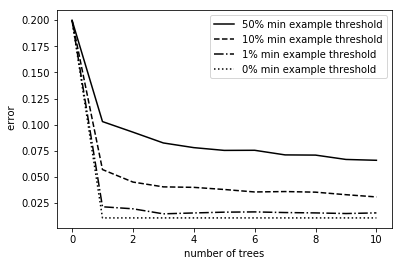

In [15]:
import matplotlib.pyplot as plt


def plot_boosting(data, steps=10, thresholds=[0.5, 0.1, 0.01, 0.001], markers=['-','--','-.',':'] ):
    learners = [Boosting_learner(data, sp_DT_learner(th)) for th in thresholds]
    predictors = [learner.learn(steps) for learner in learners]
    plt.ion()
    plt.xscale('linear')  # change between log and linear scale
    plt.xlabel('number of trees')
    plt.ylabel(' error')
    for (learner, (threshold, marker)) in zip(learners, zip(thresholds, markers)):
        plt.plot(
            range(len(learner.errors)),
            learner.errors,
            ls=marker,
            c='k',
            label=str(round(threshold * 100)) + '% min example threshold'
        )
    plt.legend()
    plt.draw()

plot_boosting(data)
